In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

cd /content/drive/MyDrive/100_days_of_Deep_Learning/TIME-SERIES-ANALYSIS/HouseHold-Power-Consumption

/content/drive/MyDrive/100_days_of_Deep_Learning/TIME-SERIES-ANALYSIS/HouseHold-Power-Consumption


In [ ]:
!ls

1.ipynb  household_power_consumption.txt  Working-of-the-Project.gdoc


In [ ]:

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score

# for Deep-learing:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import itertools

import random

In [ ]:
# Set random seed for reproducibility

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
'''
data_frame = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')

If we use this method to read the csv, then it gives warning ,because many of the above used methods are deprecated and will be removed in future version . the warnings are :

1. Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
2. The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default,
   see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
3. Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

To avoid this we use below method :

'''


# Load the data without parsing dates initially
data_frame = pd.read_csv('household_power_consumption.txt', sep=';',
                         na_values=['nan','?'], low_memory=False)

# Combine 'Date' and 'Time' into a single datetime column
data_frame['dt'] = pd.to_datetime(data_frame['Date'] + ' ' + data_frame['Time'], dayfirst=True)

# Drop the 'Date' and 'Time' columns as they are no longer needed
data_frame.drop(columns=['Date', 'Time'], inplace=True)

# Set 'dt' as the index
data_frame.set_index('dt', inplace=True)

# Now, 'data_frame' has a datetime index, and the deprecated warnings should be gone.


In [ ]:
data_frame.head()

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [ ]:
data_frame.tail()

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2010-11-26 20:58:00                0.946                    0.0   240.43   
2010-11-26 20:59:00                0.944                    0.0   240.00   
2010-11-26 21:00:00                0.938                    0.0   239.82   
2010-11-26 21:01:00                0.934                    0.0   239.70   
2010-11-26 21:02:00                0.932                    0.0   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
dt                                   
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0

In [ ]:
# number of rows and columns in the dataset
data_frame.shape

(2075259, 7)

In [ ]:
# getting some info about the data
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
# checking for missing values
data_frame.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# statistical measures about the data
data_frame.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [ ]:
data_frame.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

### **Missing value Fill using avg**

In [ ]:
# Select the column
g_active = data_frame[['Global_active_power']]

# Apply different filling techniques
g_linear = g_active.interpolate(method='linear')
g_ffill = g_active.fillna(method='ffill')
g_combined = g_active.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(g_active, label='Original with Missing', linestyle='--', marker='o', alpha=0.5)
plt.plot(g_linear, label='Linear Interpolation')
plt.plot(g_ffill, label='Forward Fill')
plt.plot(g_combined, label='Linear + FFill + BFill', linestyle=':')

plt.title('Imputation Methods for Global_active_power')
plt.xlabel('Time')
plt.ylabel('Global_active_power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
droping_list_all=[]
for j in range(0,7):
    if not data_frame.iloc[:, j].notnull().all():
        droping_list_all.append(j)

droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
for j in range(0,7):
        data_frame.iloc[:,j]=data_frame.iloc[:,j].fillna(data_frame.iloc[:,j].mean())

In [ ]:
# checking for missing values
data_frame.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
# statistical measures about the data
data_frame.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.050655e+00           1.120142e-01  3.219643e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.100000e-01           4.800000e-02  2.390200e+02   
50%           6.300000e-01           1.020000e-01  2.409600e+02   
75%           1.520000e+00           1.920000e-01  2.428600e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.416490e+00    6.114397e+00    5.785470e+00    8.384178e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.800000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

### **Data visualization**

In [ ]:
# Set aesthetic parameters for plots
sns.set(style="whitegrid", palette="Set2")

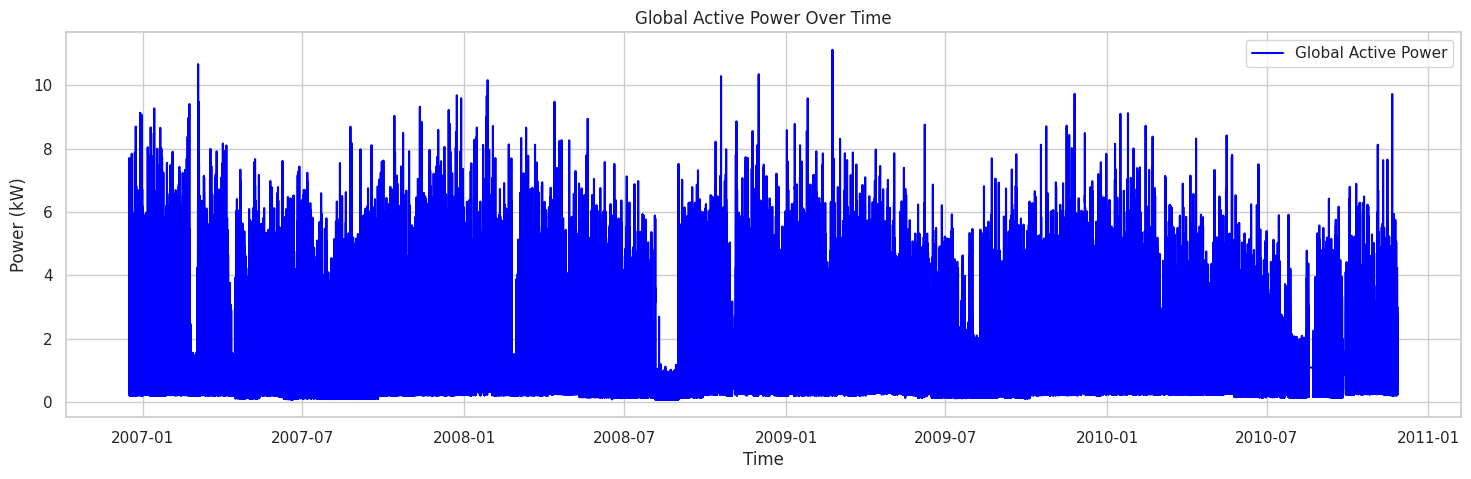

In [ ]:
#1. Line Plot (Time Series Trend)

# here patterns are not properly visible so break it further and then plot ..

plt.figure(figsize=(18, 5))
plt.plot(data_frame.index, data_frame['Global_active_power'], label="Global Active Power", color='blue')
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Global Active Power Over Time")
plt.legend()
plt.show()

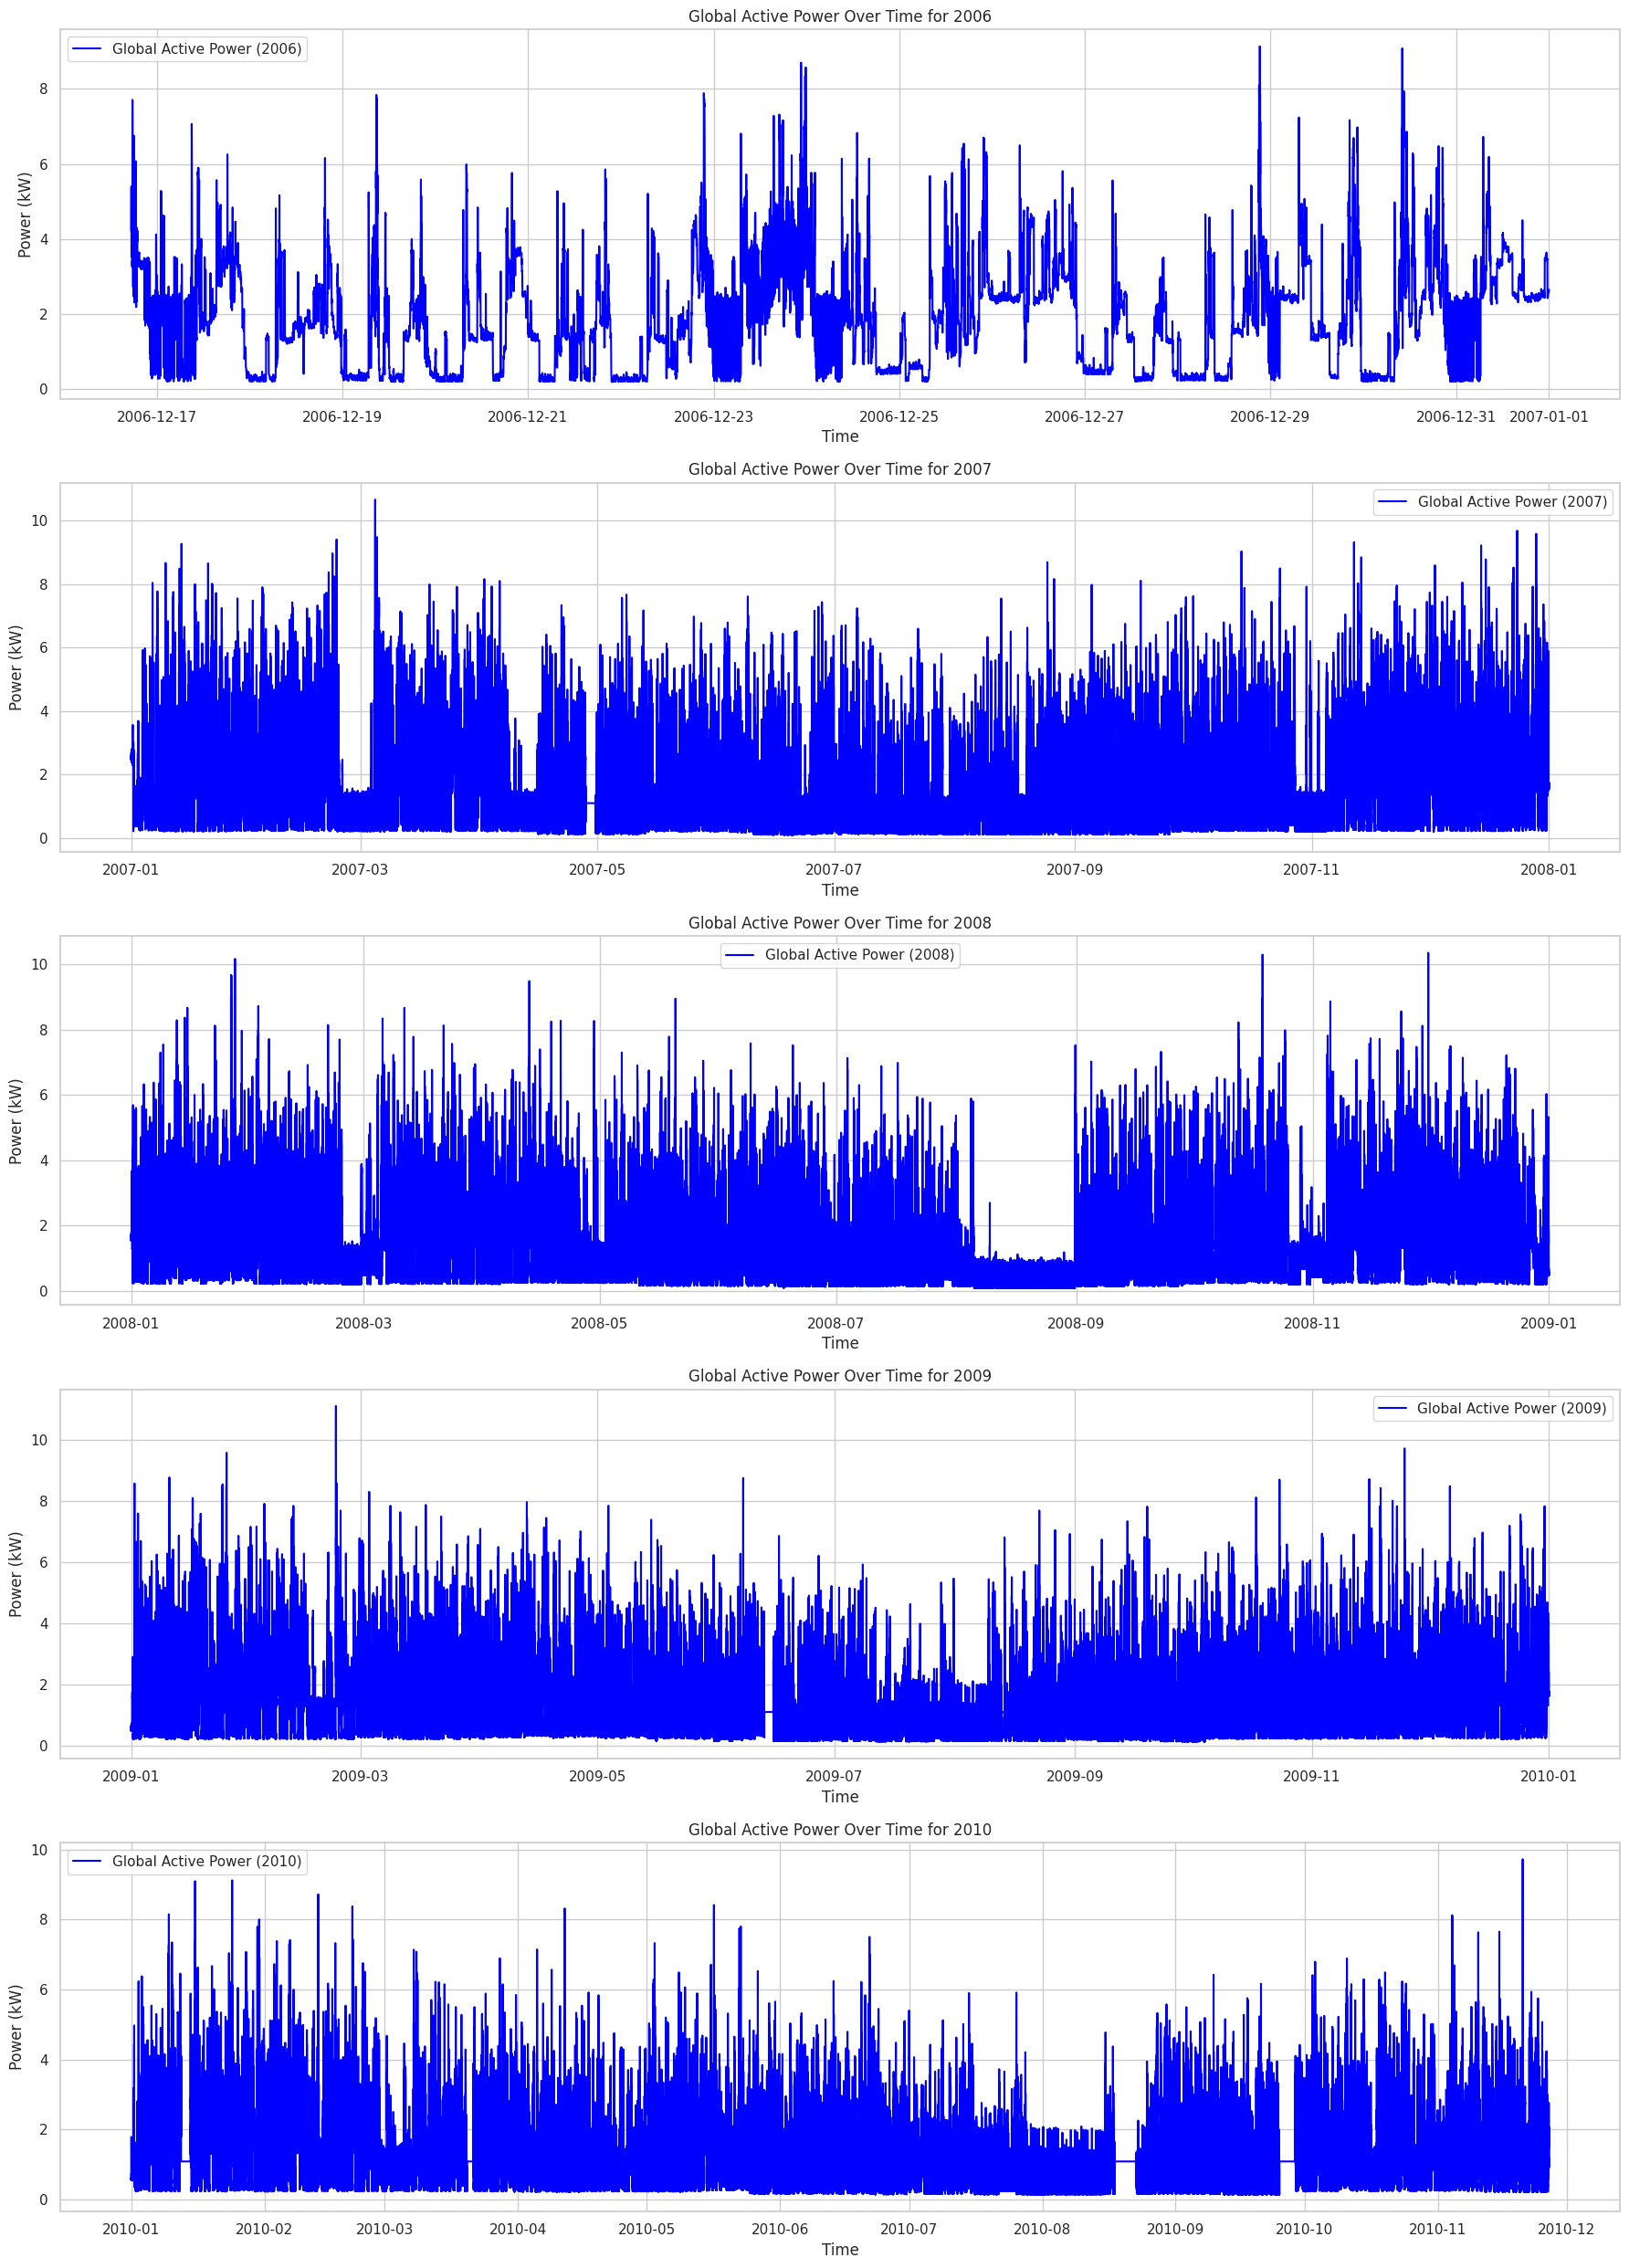

In [ ]:
import matplotlib.pyplot as plt

# Ensure the datetime index is properly set (in case it's not)
data_frame.index = pd.to_datetime(data_frame.index)

# Extract years from the datetime index
data_frame['Year'] = data_frame.index.year

# Unique years in the data
years = data_frame['Year'].unique()

# Create a figure with subplots (5 rows, 1 column)
fig, axes = plt.subplots(len(years), 1, figsize=(18, len(years)*5))

# Plot for each year
for i, year in enumerate(years):
    # Filter data for the given year
    yearly_data = data_frame[data_frame['Year'] == year]

    # Plot Global Active Power for the given year
    axes[i].plot(yearly_data.index, yearly_data['Global_active_power'], label=f"Global Active Power ({year})", color='blue')

    # Set labels and title
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Power (kW)")
    axes[i].set_title(f"Global Active Power Over Time for {year}")
    axes[i].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [ ]:
# number of rows and columns in the dataset
data_frame.shape

(2075259, 8)

<ipython-input-22-1affab9c6e38>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg_data = data_frame.resample('H').mean()  # Resample by hour, taking the mean of each column


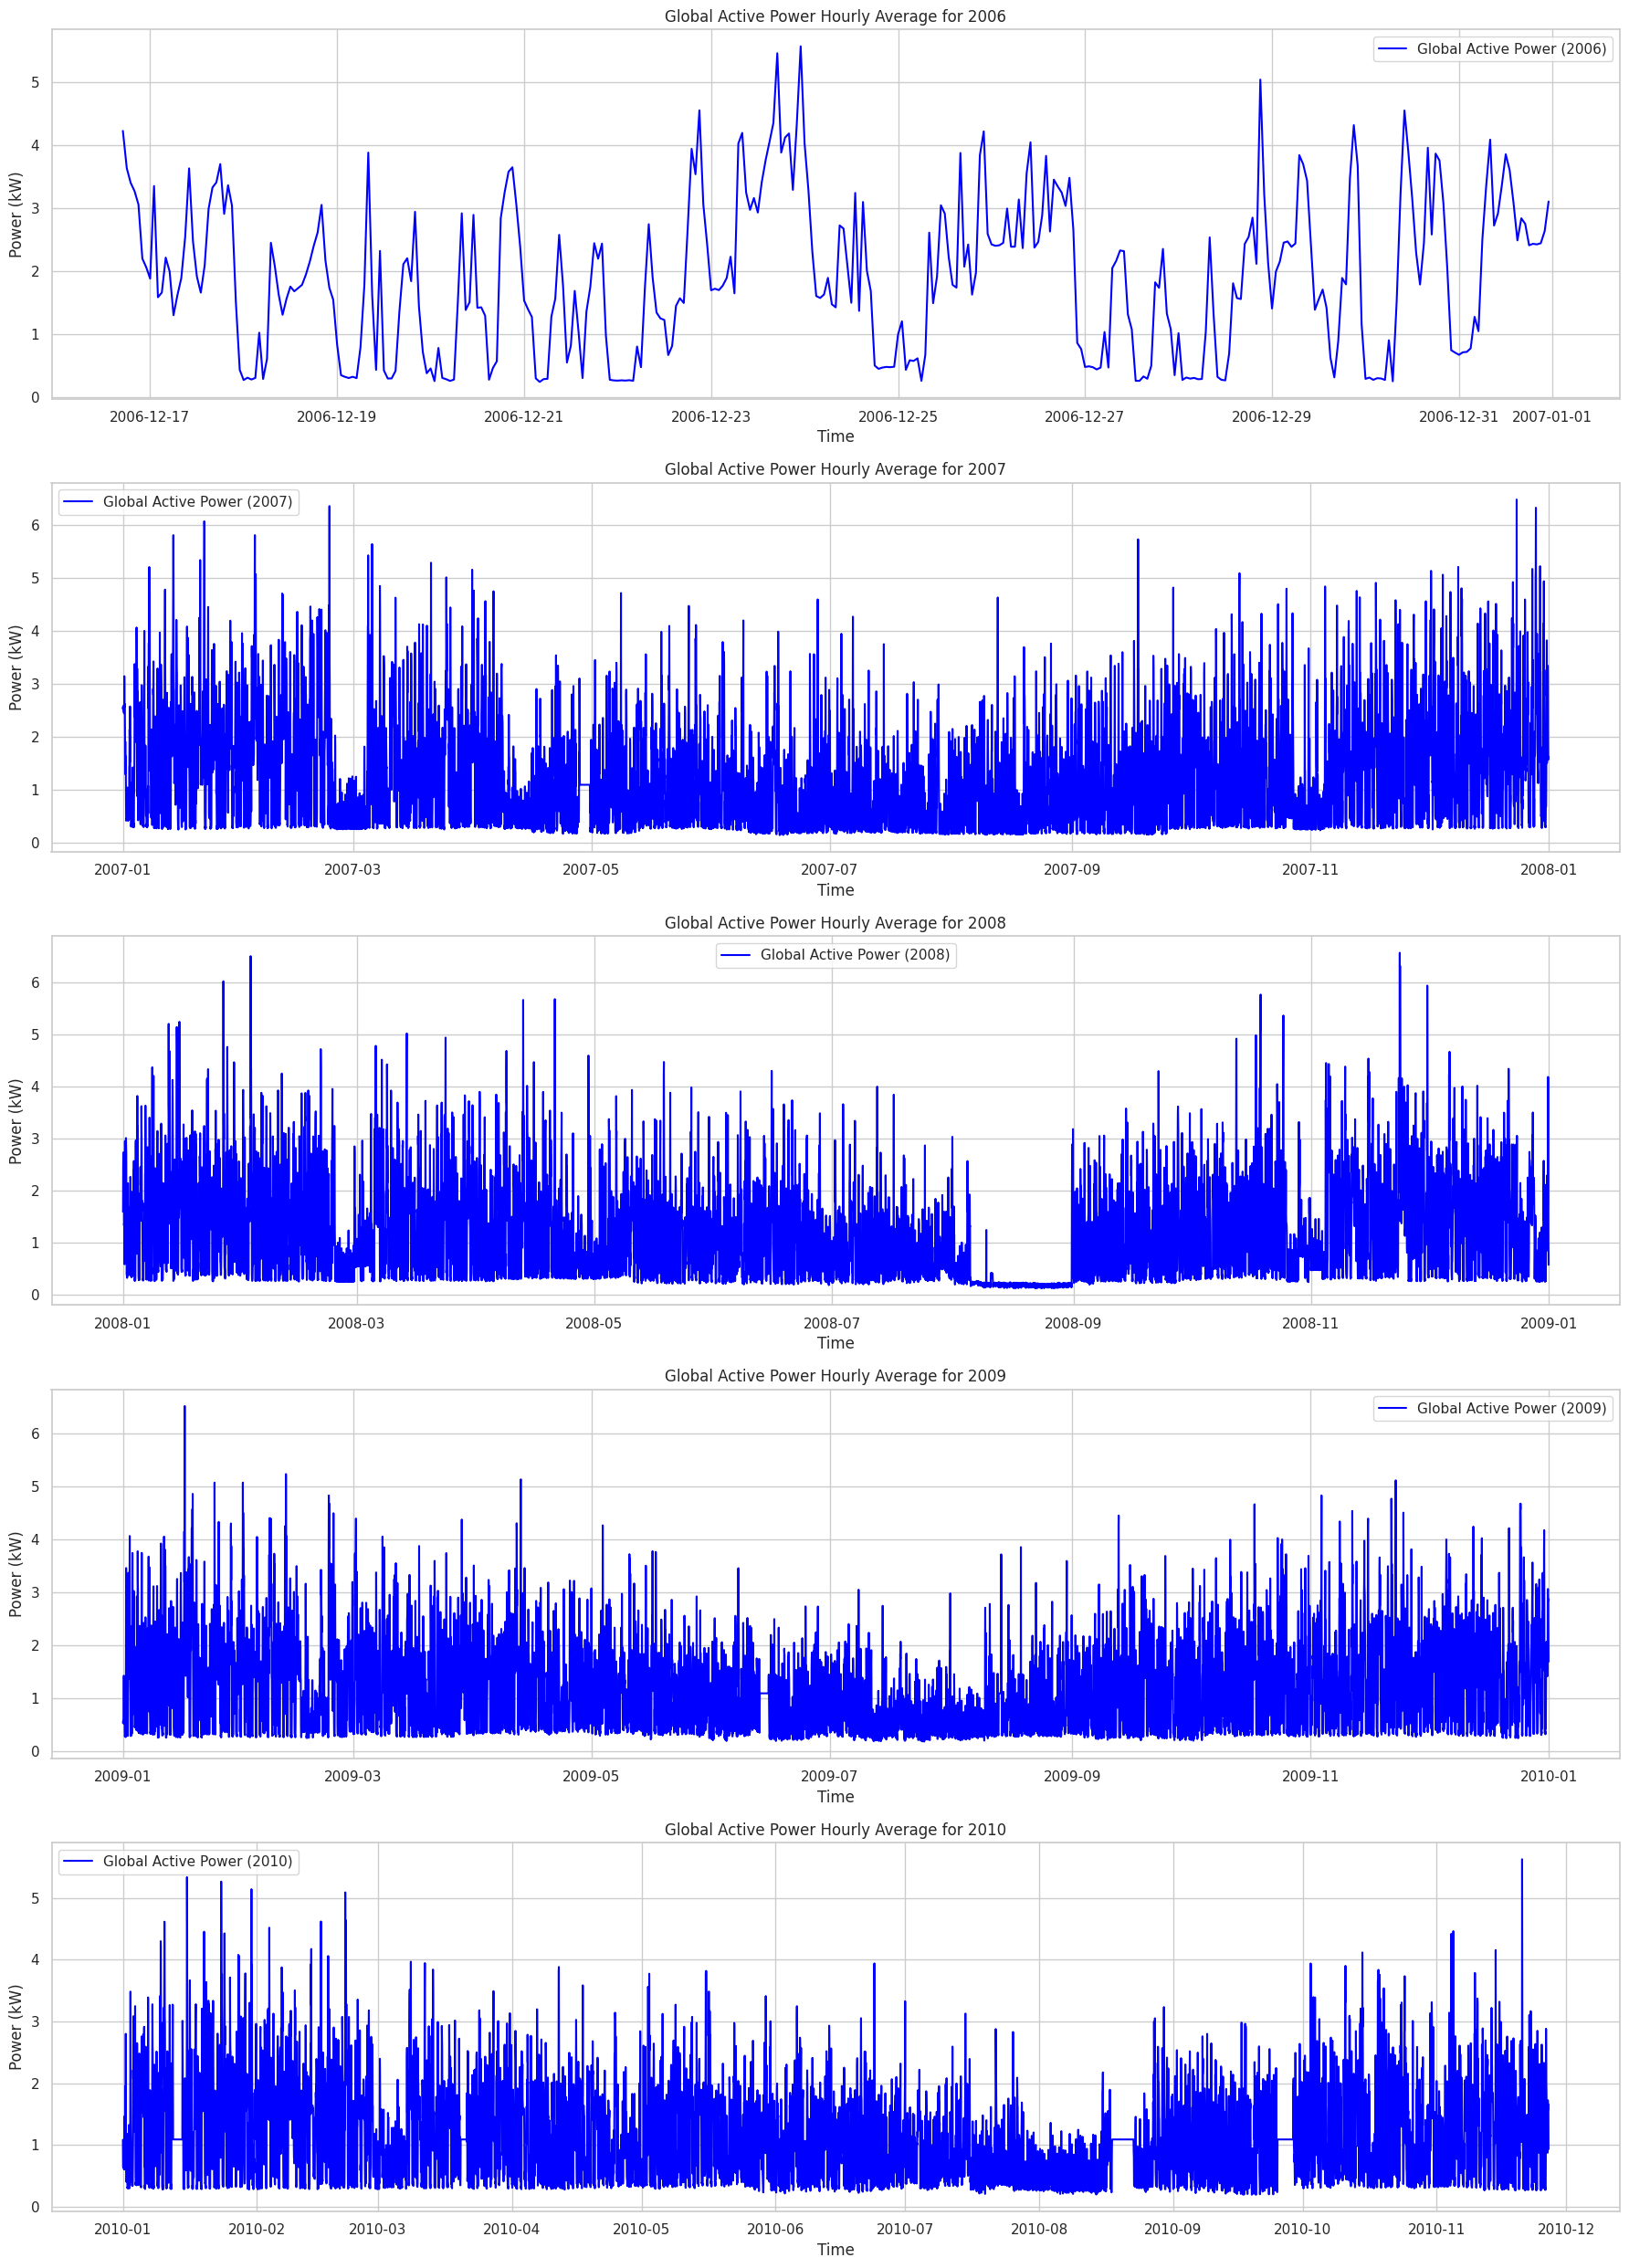

In [ ]:
import matplotlib.pyplot as plt

# Ensure the datetime index is properly set (in case it's not)
data_frame.index = pd.to_datetime(data_frame.index)

# Resample the data by hour, calculating the mean of each hour's data
hourly_avg_data = data_frame.resample('H').mean()  # Resample by hour, taking the mean of each column

# Extract years
years = hourly_avg_data.index.year.unique()

# Create a figure with subplots
fig, axes = plt.subplots(len(years), 1, figsize=(18, len(years)*5))

# Plot hourly average for each year
for i, year in enumerate(years):
    # Filter hourly data for the given year
    yearly_data = hourly_avg_data[hourly_avg_data.index.year == year]

    # Plot Global Active Power for the given year
    axes[i].plot(yearly_data.index, yearly_data['Global_active_power'], label=f"Global Active Power ({year})", color='blue')

    # Set labels and title
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Power (kW)")
    axes[i].set_title(f"Global Active Power Hourly Average for {year}")
    axes[i].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


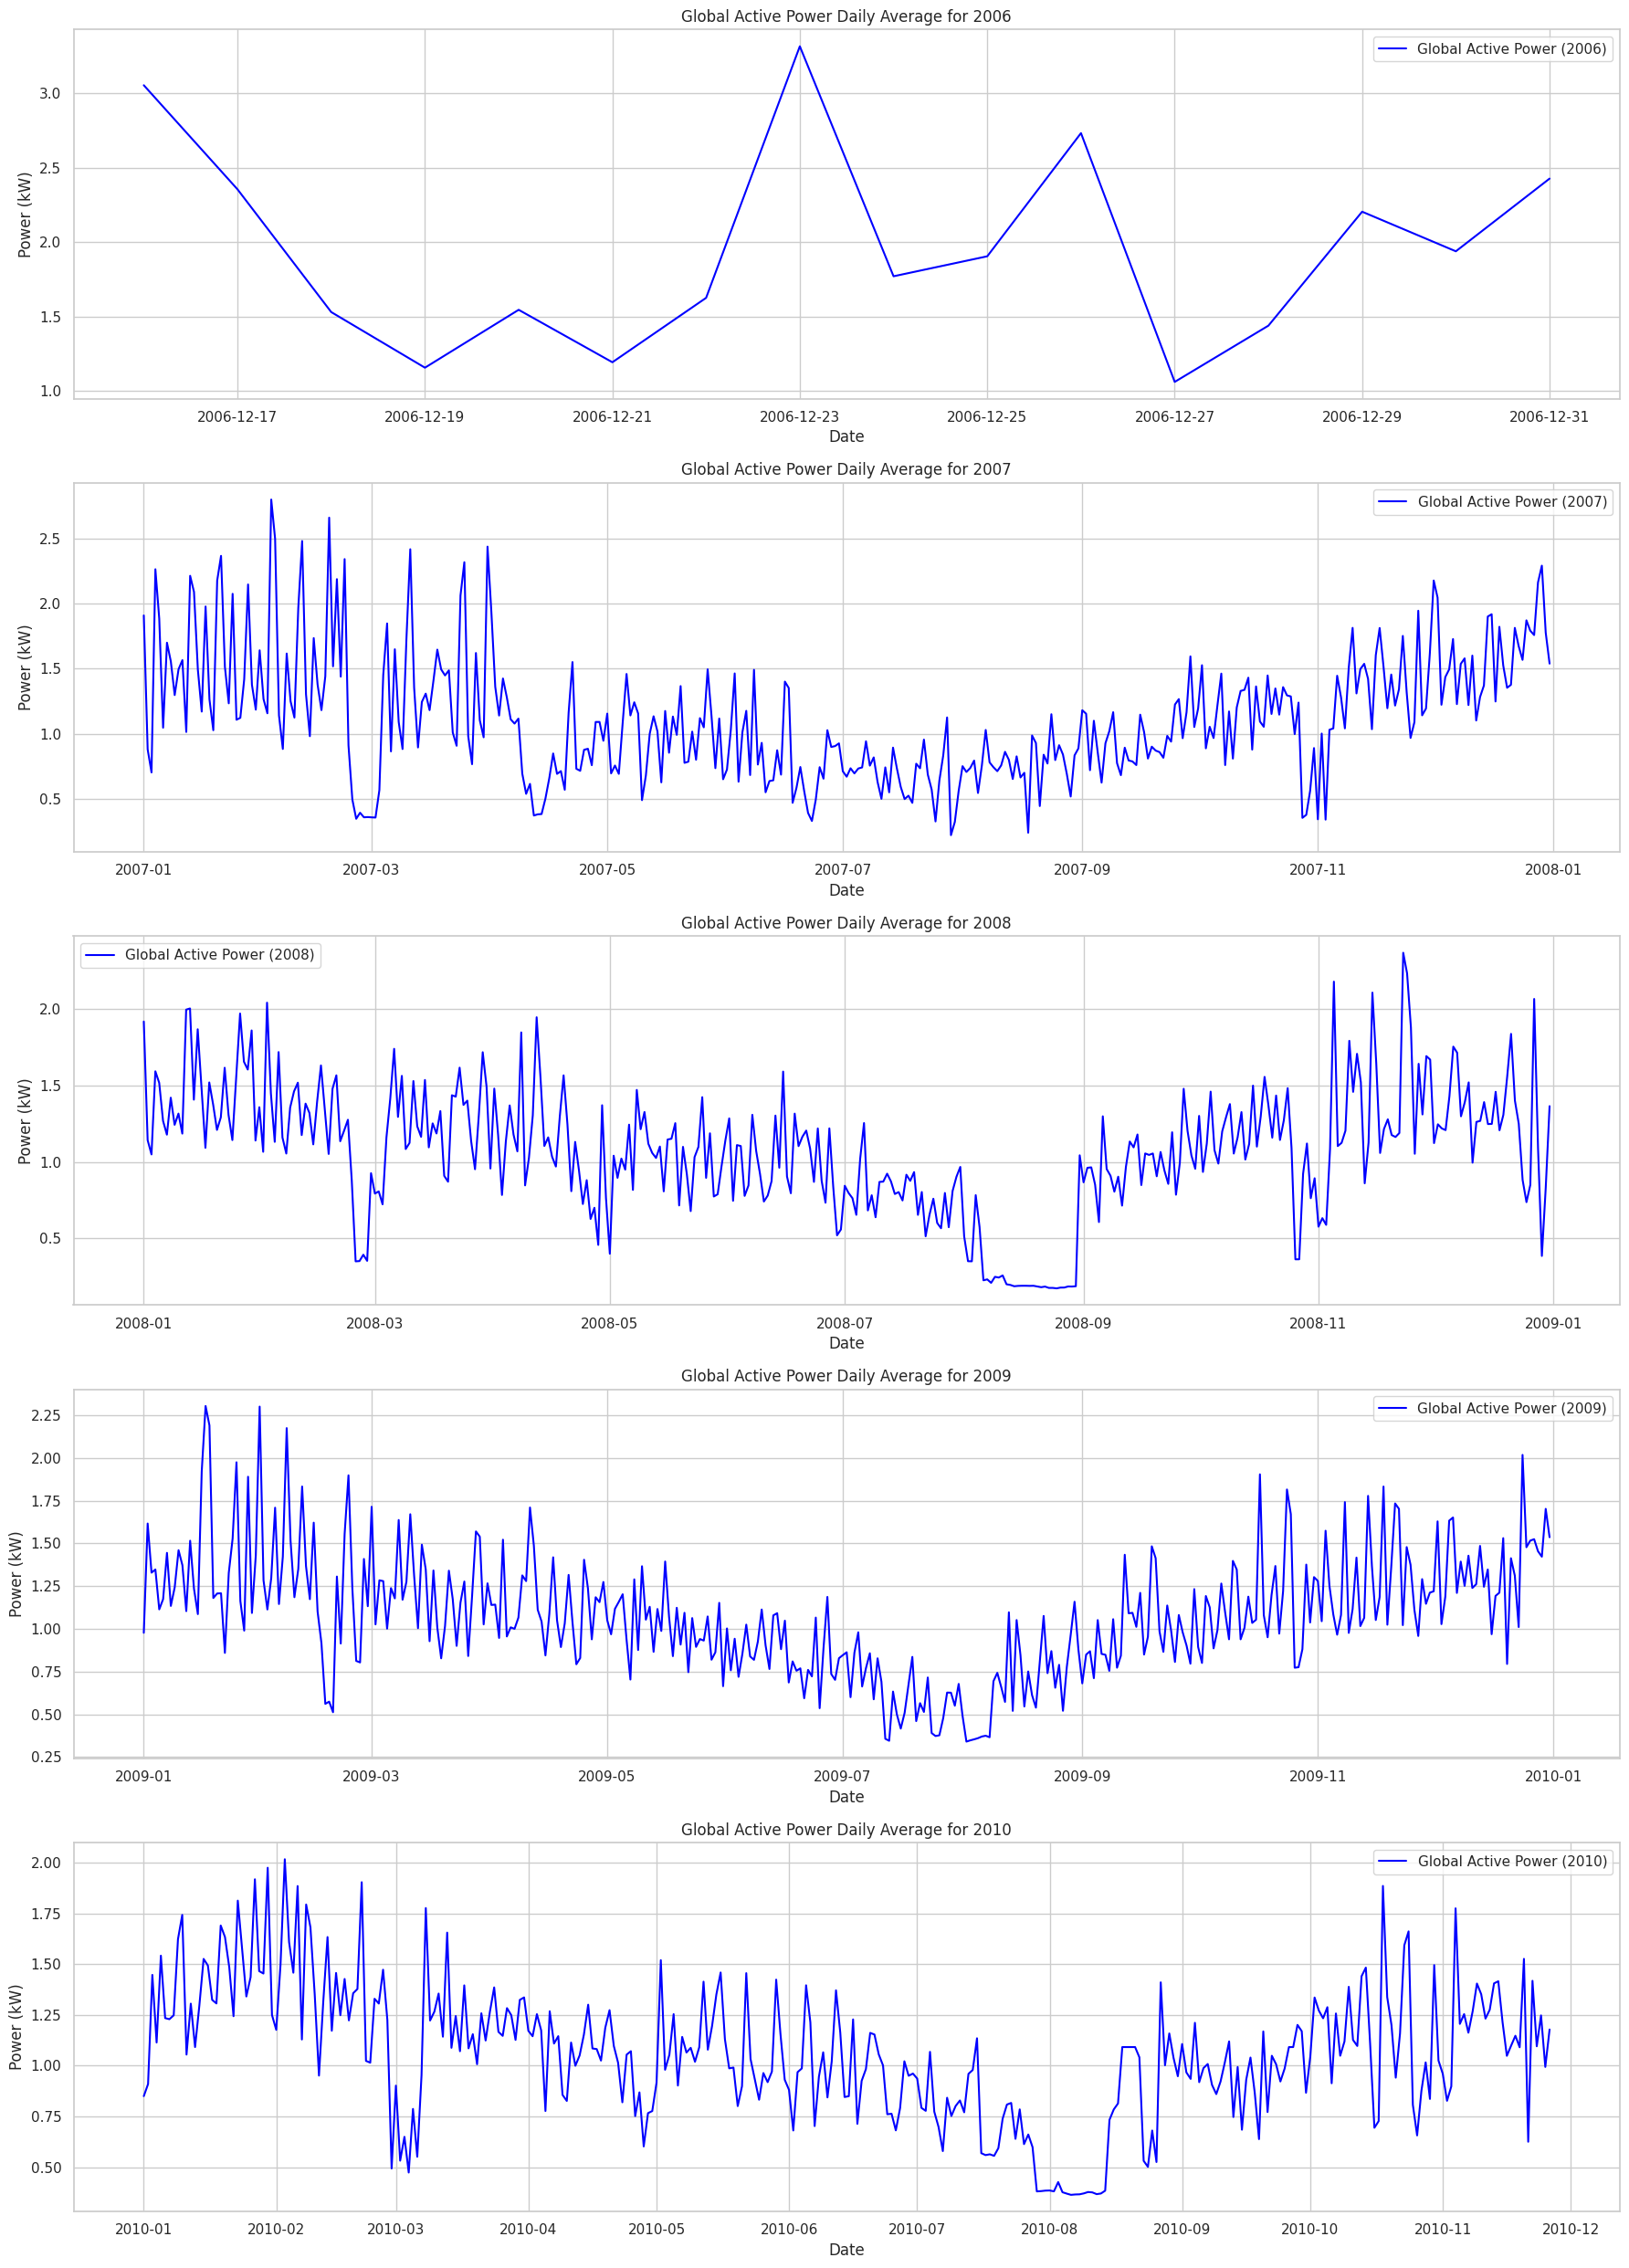

In [ ]:
import matplotlib.pyplot as plt

# Ensure the datetime index is properly set (in case it's not)
data_frame.index = pd.to_datetime(data_frame.index)

# Resample the data by day, calculating the mean of each day's data
daily_avg_data = data_frame.resample('D').mean()  # Resample by day, taking the mean of each column

# Extract years
years = daily_avg_data.index.year.unique()

# Create a figure with subplots
fig, axes = plt.subplots(len(years), 1, figsize=(18, len(years)*5))

# Plot daily average for each year
for i, year in enumerate(years):
    # Filter daily data for the given year
    yearly_data = daily_avg_data[daily_avg_data.index.year == year]

    # Plot Global Active Power for the given year
    axes[i].plot(yearly_data.index, yearly_data['Global_active_power'], label=f"Global Active Power ({year})", color='blue')

    # Set labels and title
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Power (kW)")
    axes[i].set_title(f"Global Active Power Daily Average for {year}")
    axes[i].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


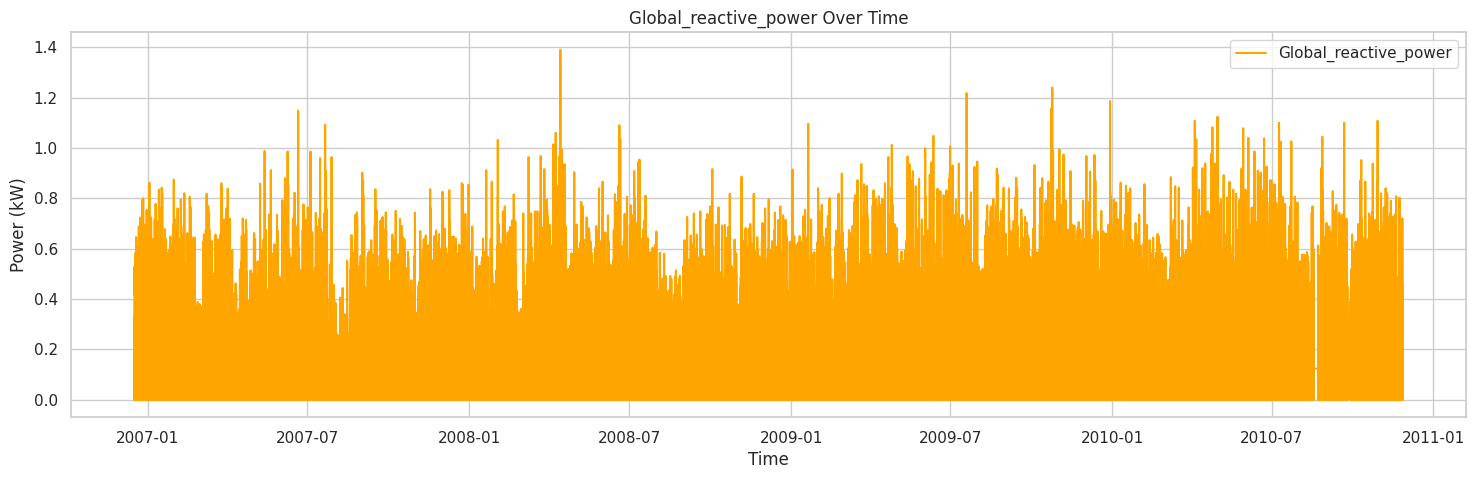

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(data_frame.index, data_frame['Global_reactive_power'], label="Global_reactive_power", color='orange')
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Global_reactive_power Over Time")
plt.legend()
plt.show()

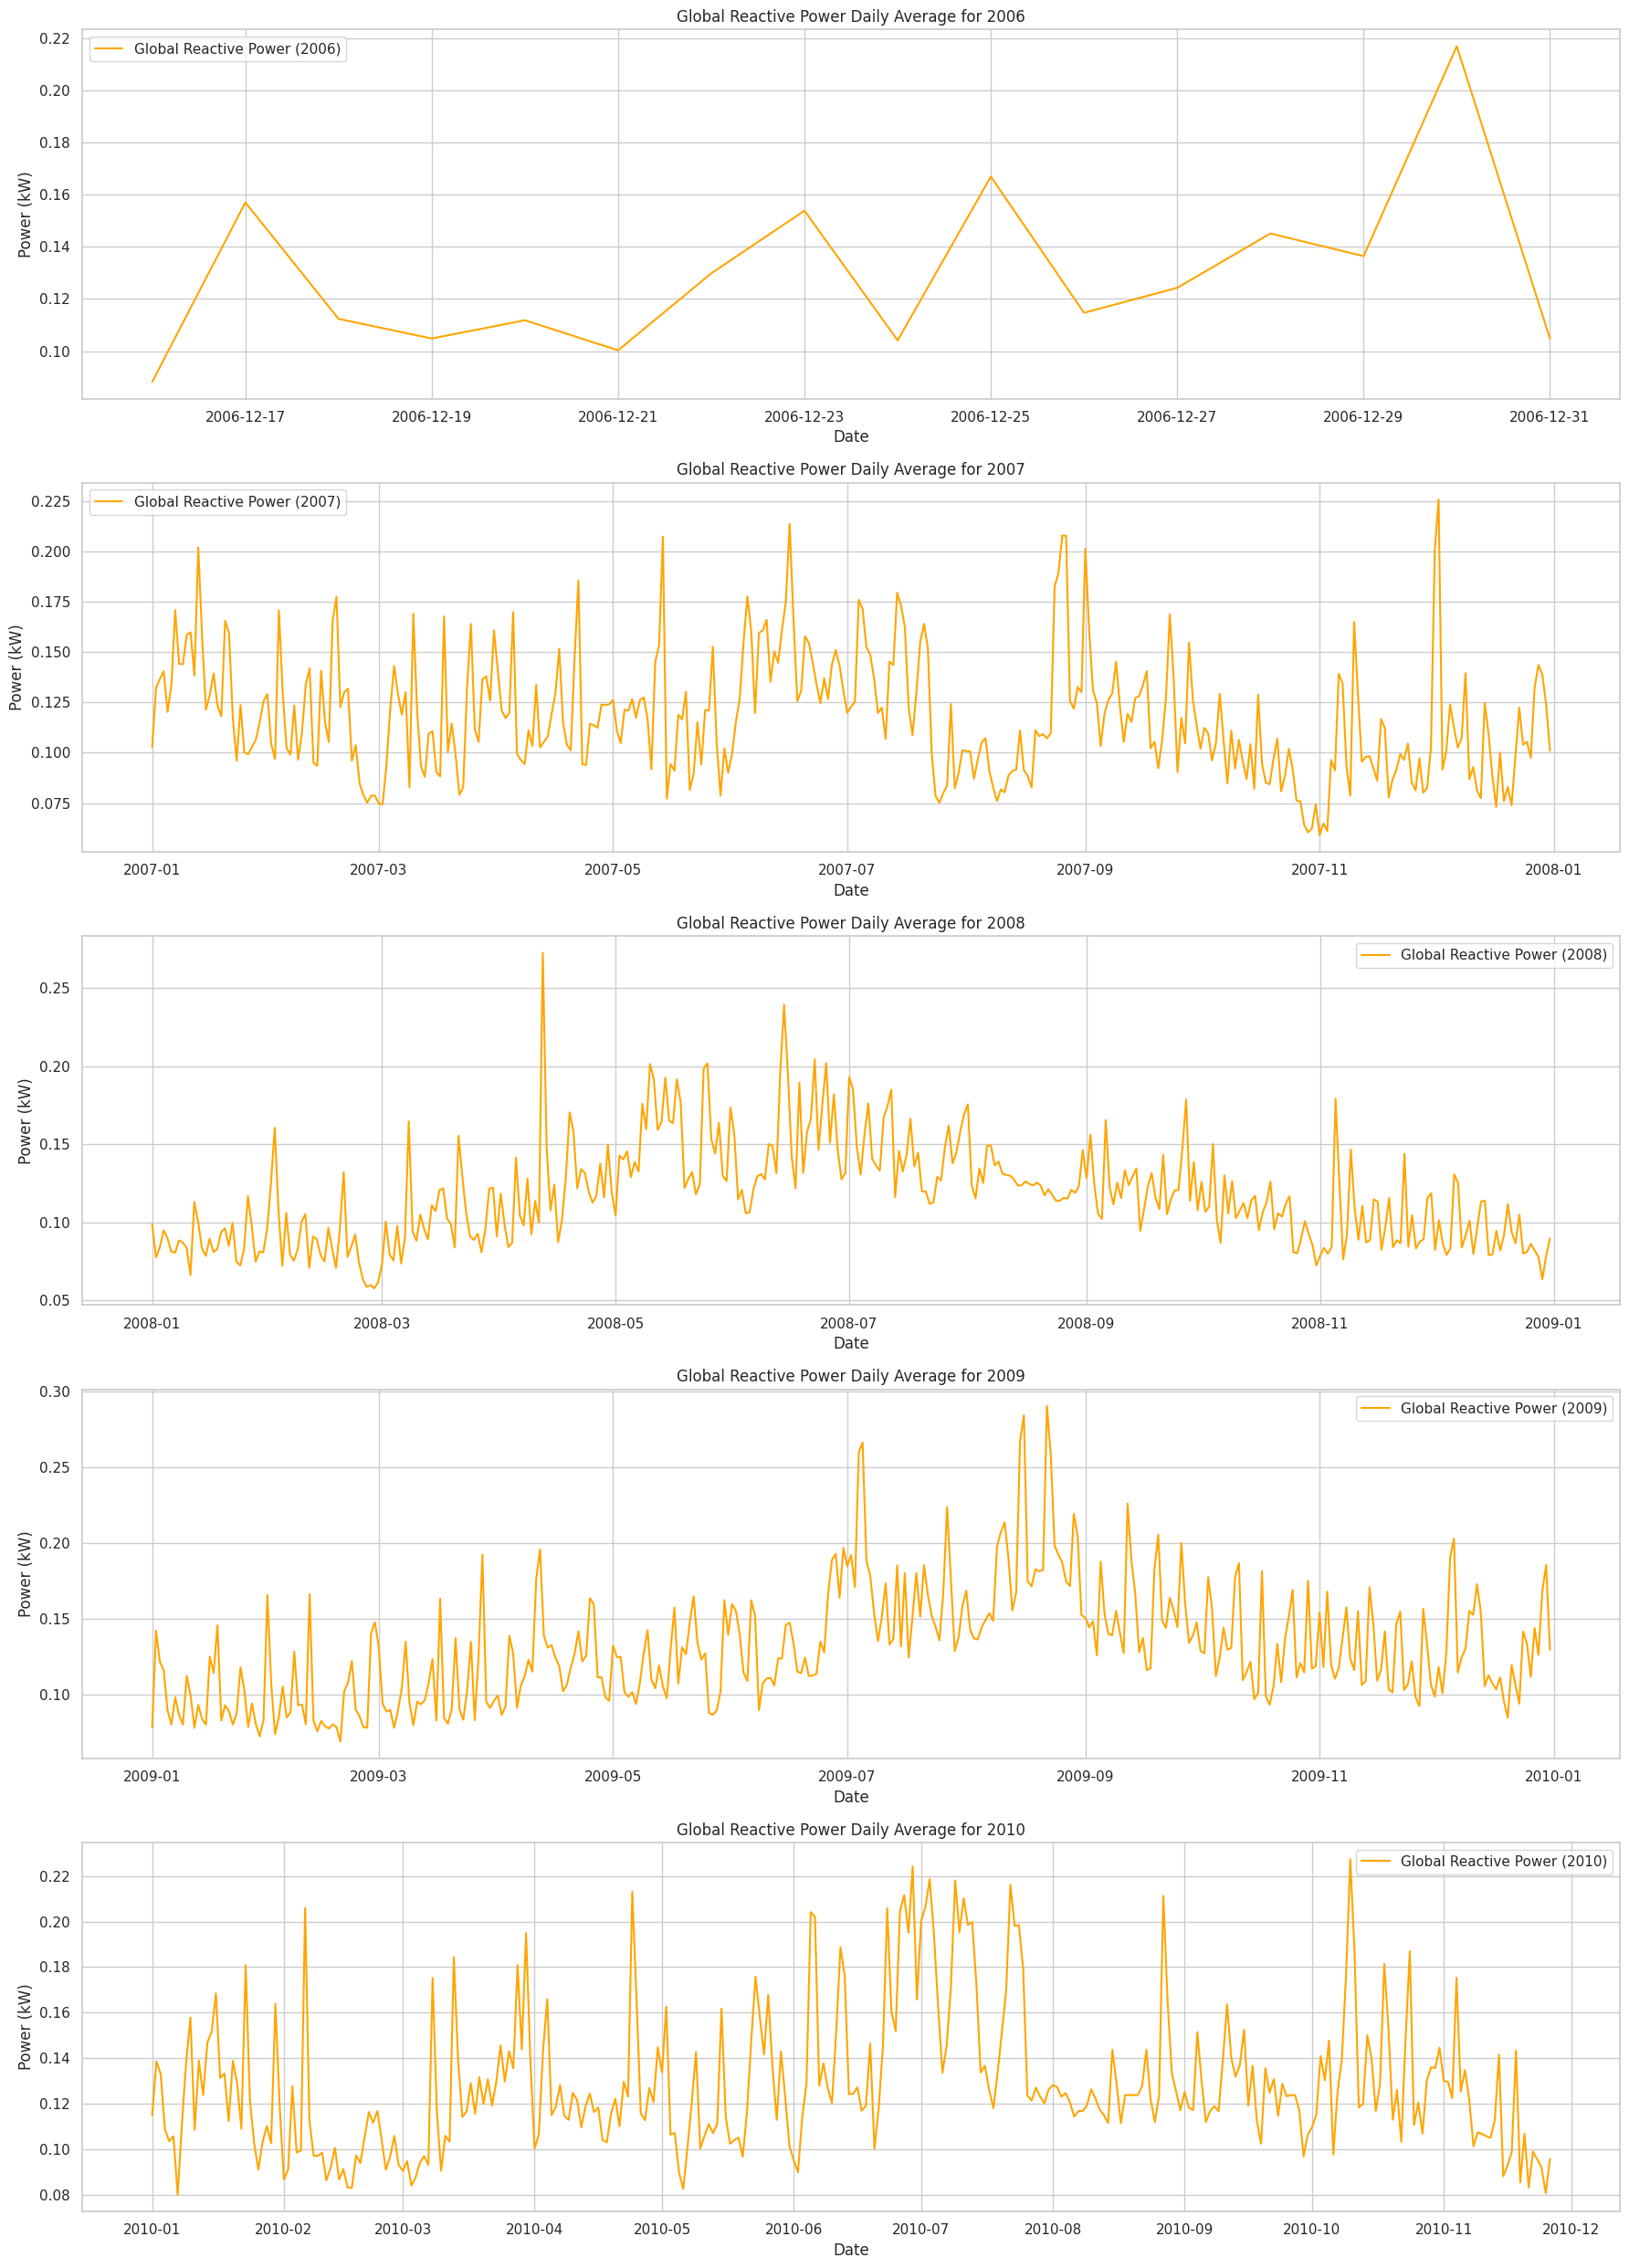

In [ ]:
import matplotlib.pyplot as plt

# Ensure the datetime index is properly set (in case it's not)
data_frame.index = pd.to_datetime(data_frame.index)

# Resample the data by day, calculating the mean of each day's data
daily_avg_data = data_frame.resample('D').mean()  # Resample by day, taking the mean of each column

# Extract years
years = daily_avg_data.index.year.unique()

# Create a figure with subplots
fig, axes = plt.subplots(len(years), 1, figsize=(18, len(years)*5))

# Plot daily average for each year
for i, year in enumerate(years):
    # Filter daily data for the given year
    yearly_data = daily_avg_data[daily_avg_data.index.year == year]

    # Plot Global Active Power for the given year
    axes[i].plot(yearly_data.index, yearly_data['Global_reactive_power'], label=f"Global Reactive Power ({year})", color='orange')

    # Set labels and title
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Power (kW)")
    axes[i].set_title(f"Global Reactive Power Daily Average for {year}")
    axes[i].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


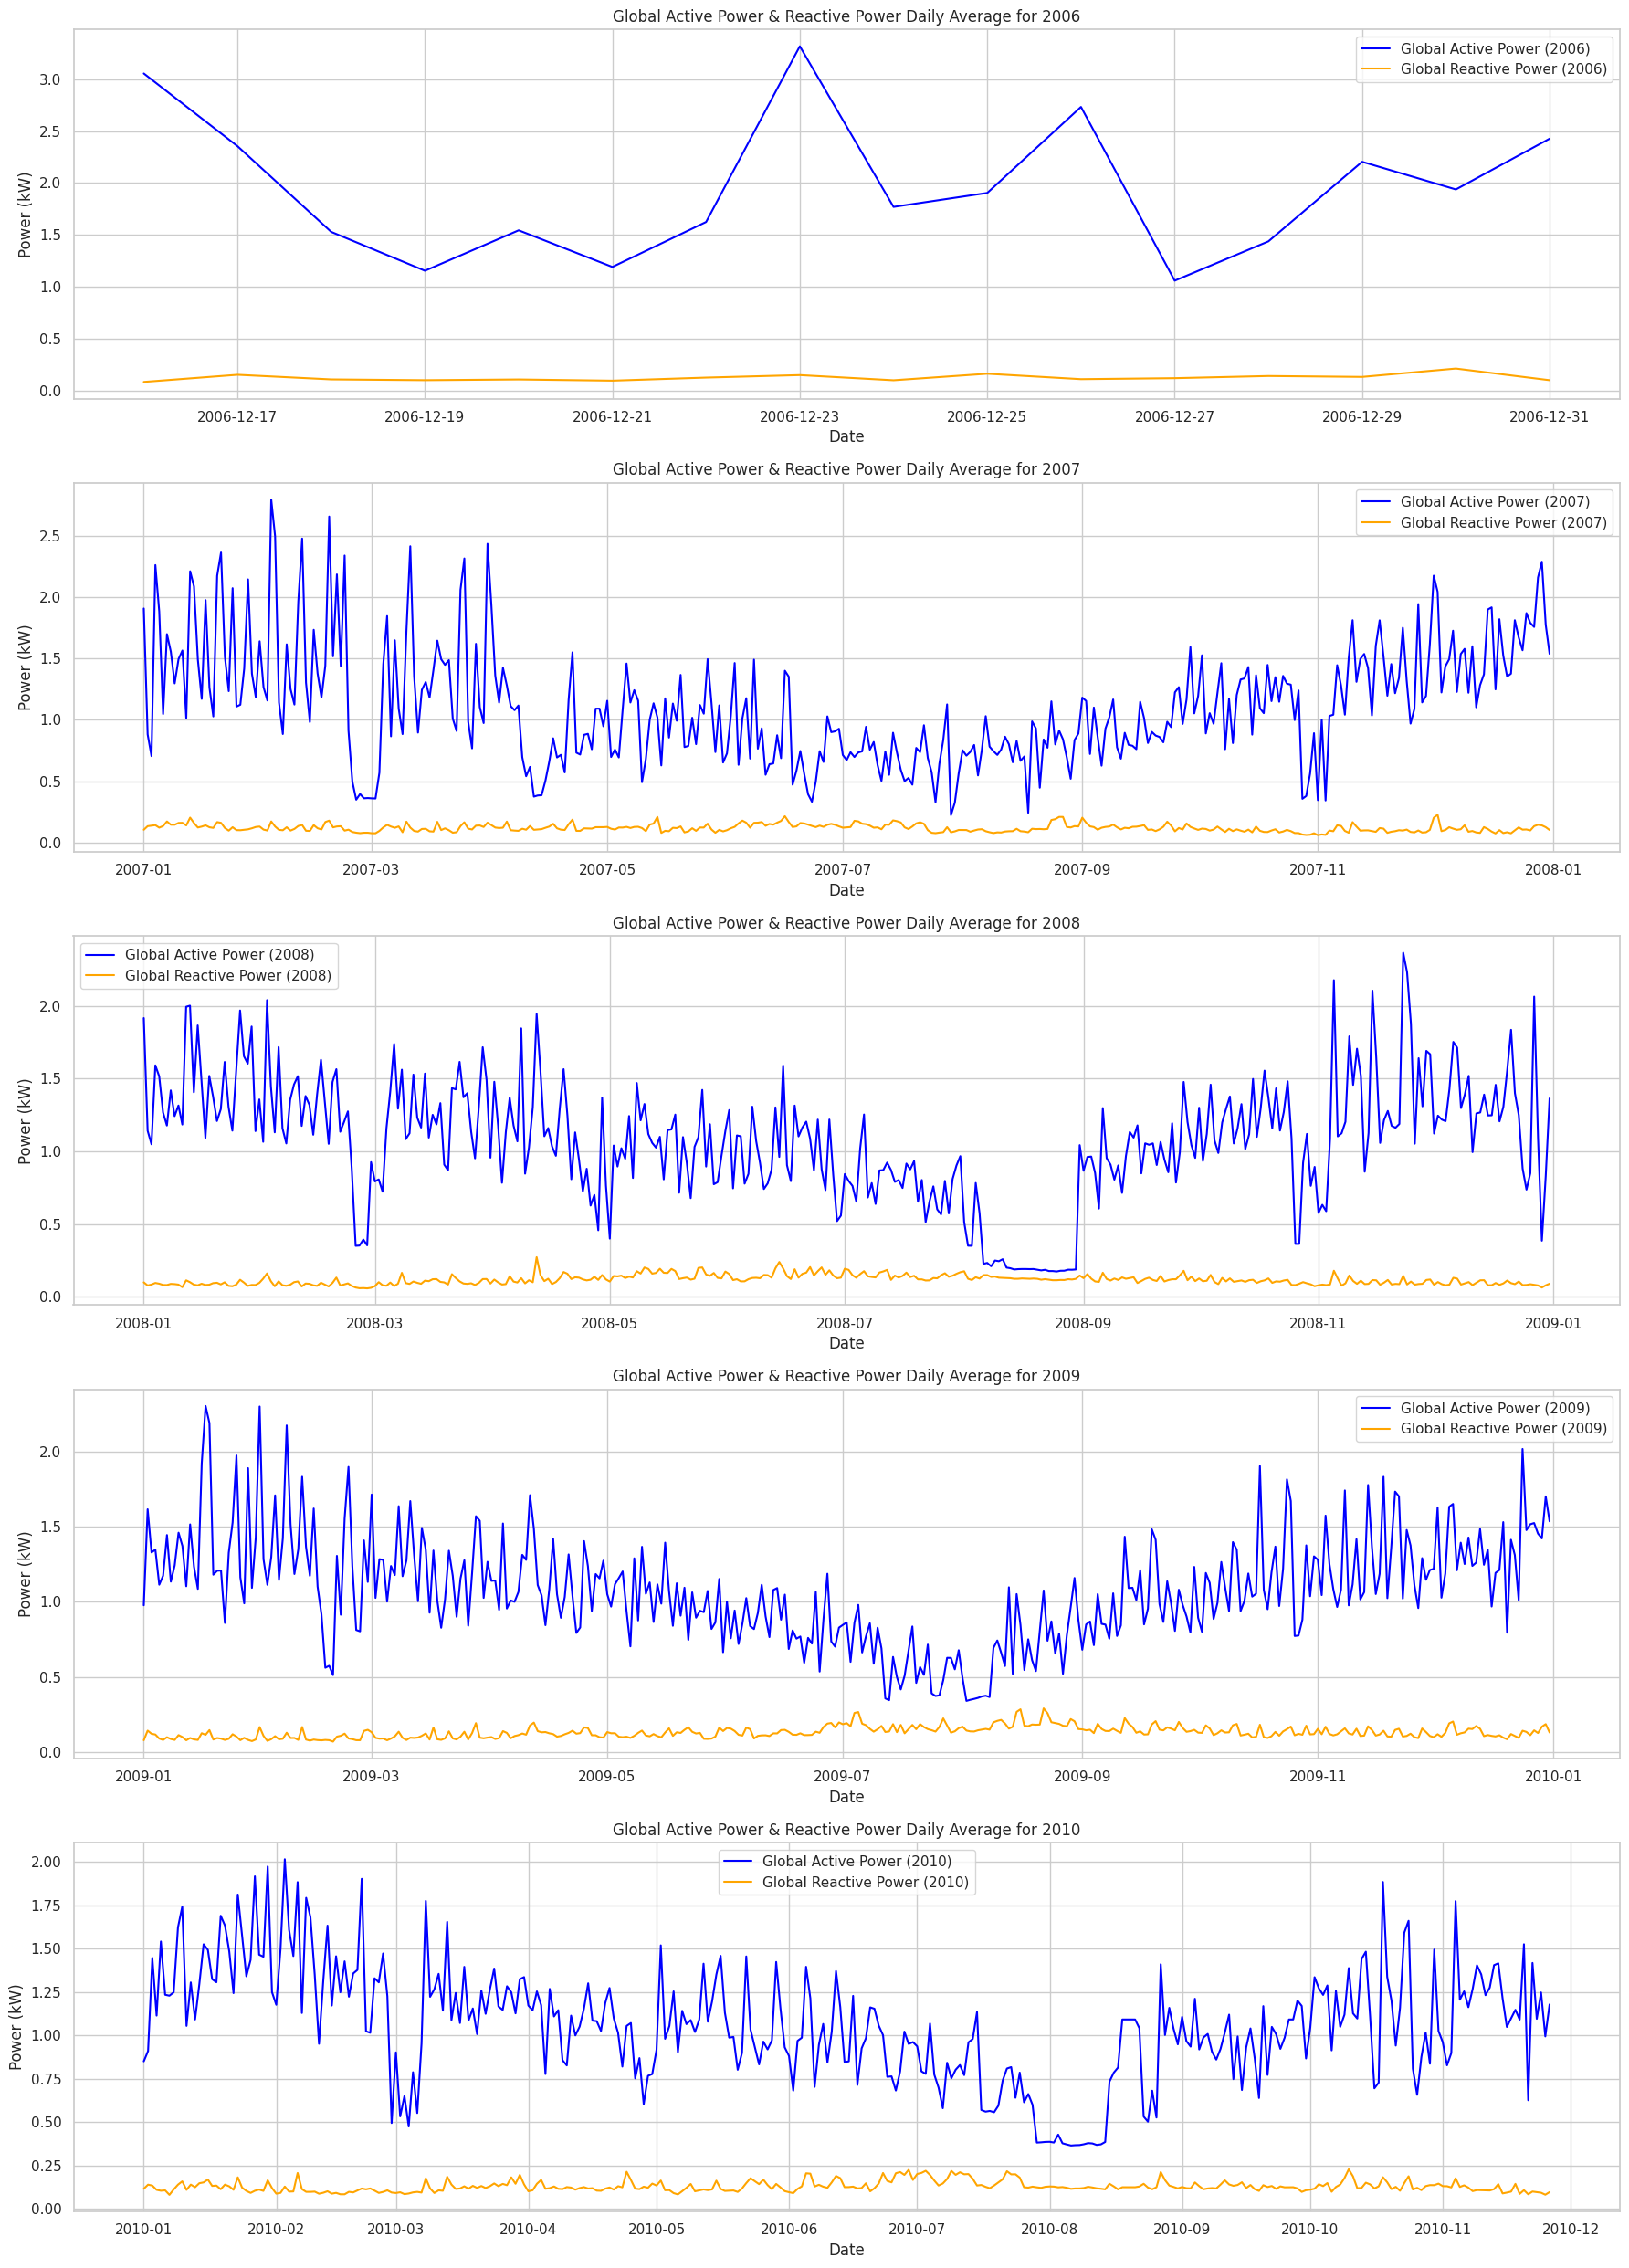

In [ ]:
import matplotlib.pyplot as plt

# Ensure the datetime index is properly set (in case it's not)
data_frame.index = pd.to_datetime(data_frame.index)

# Resample the data by day, calculating the mean of each day's data
daily_avg_data = data_frame.resample('D').mean()  # Resample by day, taking the mean of each column

# Extract years
years = daily_avg_data.index.year.unique()

# Create a figure with subplots
fig, axes = plt.subplots(len(years), 1, figsize=(18, len(years)*5))

# Plot daily average for each year
for i, year in enumerate(years):
    # Filter daily data for the given year
    yearly_data = daily_avg_data[daily_avg_data.index.year == year]

    # Plot Global Active Power for the given year (using blue color)
    axes[i].plot(yearly_data.index, yearly_data['Global_active_power'], label=f"Global Active Power ({year})", color='blue')

    # Plot Global Reactive Power for the given year (using orange color)
    axes[i].plot(yearly_data.index, yearly_data['Global_reactive_power'], label=f"Global Reactive Power ({year})", color='orange')

    # Set labels and title
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Power (kW)")
    axes[i].set_title(f"Global Active Power & Reactive Power Daily Average for {year}")
    axes[i].legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


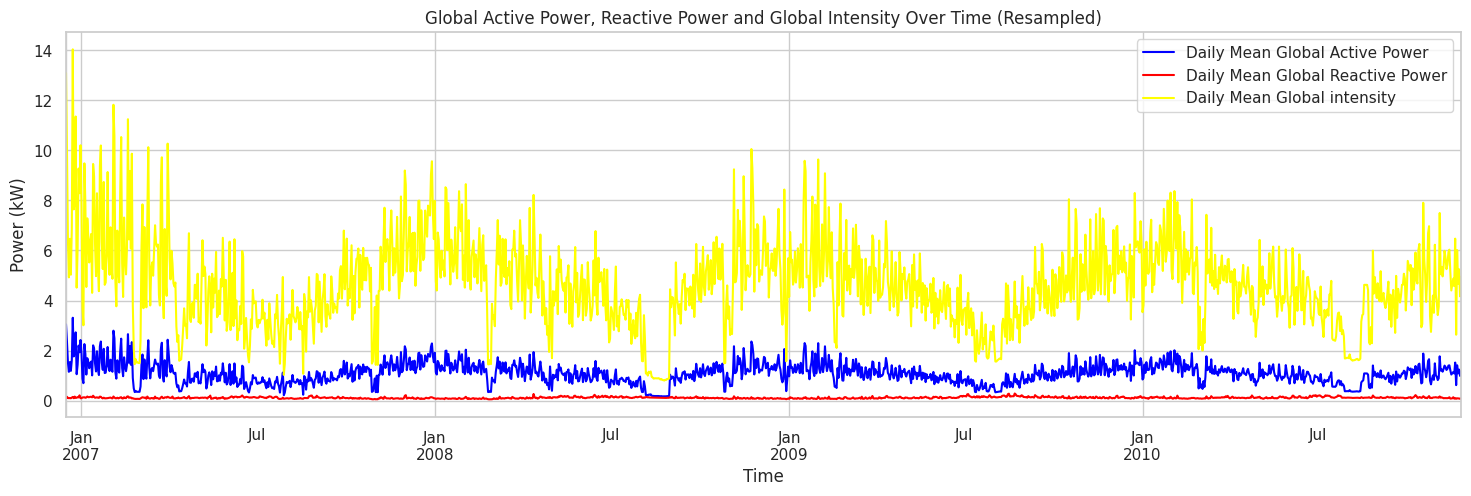

In [ ]:
plt.figure(figsize=(18, 5))

# Resampling to daily and calculating the mean for each day

data_frame['Global_active_power'].resample('D').mean().plot(label="Daily Mean Global Active Power", color='blue')
data_frame['Global_reactive_power'].resample('D').mean().plot(label="Daily Mean Global Reactive Power", color='red')
data_frame['Global_intensity'].resample('D').mean().plot(label="Daily Mean Global intensity", color='yellow')

plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Global Active Power, Reactive Power and Global Intensity Over Time (Resampled)")
plt.legend()
plt.show()


# Instead of mean we can use sum, std(starndard deviation) etc ..


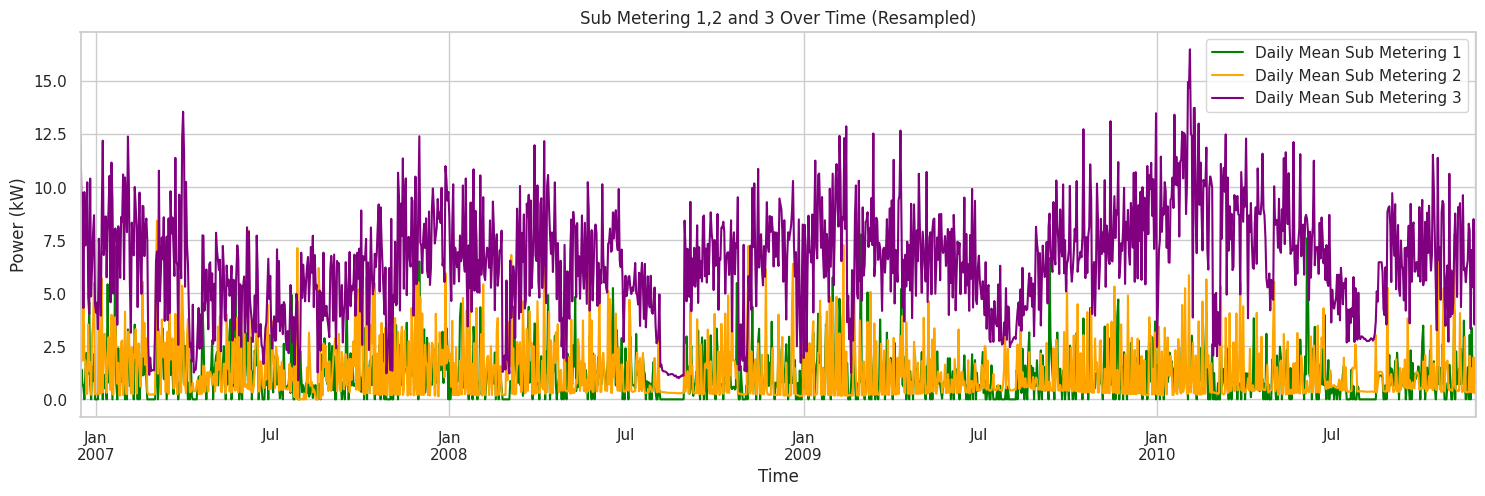

In [ ]:
plt.figure(figsize=(18, 5))

# Resampling to daily and calculating the mean for each day
data_frame['Sub_metering_1'].resample('D').mean().plot(label="Daily Mean Sub Metering 1", color='green')
data_frame['Sub_metering_2'].resample('D').mean().plot(label="Daily Mean Sub Metering 2", color='orange')
data_frame['Sub_metering_3'].resample('D').mean().plot(label="Daily Mean Sub Metering 3", color='purple')
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Sub Metering 1,2 and 3 Over Time (Resampled)")
plt.legend()
plt.show()

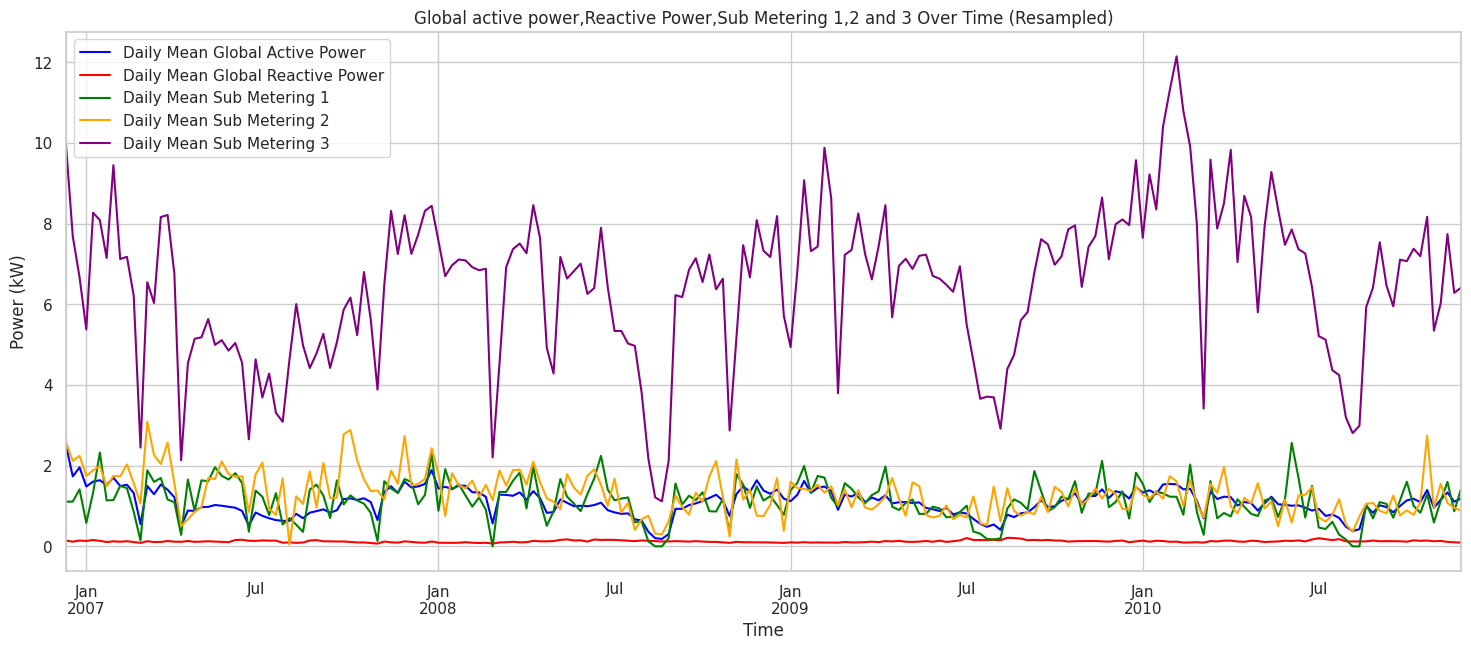

In [ ]:
plt.figure(figsize=(18, 7))

# Resampling to Weekly and calculating the mean for each day

data_frame['Global_active_power'].resample('W').mean().plot(label="Daily Mean Global Active Power", color='blue')
data_frame['Global_reactive_power'].resample('W').mean().plot(label="Daily Mean Global Reactive Power", color='red')
data_frame['Sub_metering_1'].resample('W').mean().plot(label="Daily Mean Sub Metering 1", color='green')
data_frame['Sub_metering_2'].resample('W').mean().plot(label="Daily Mean Sub Metering 2", color='orange')
data_frame['Sub_metering_3'].resample('W').mean().plot(label="Daily Mean Sub Metering 3", color='purple')
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Global active power,Reactive Power,Sub Metering 1,2 and 3 Over Time (Resampled)")
plt.legend()
plt.show()

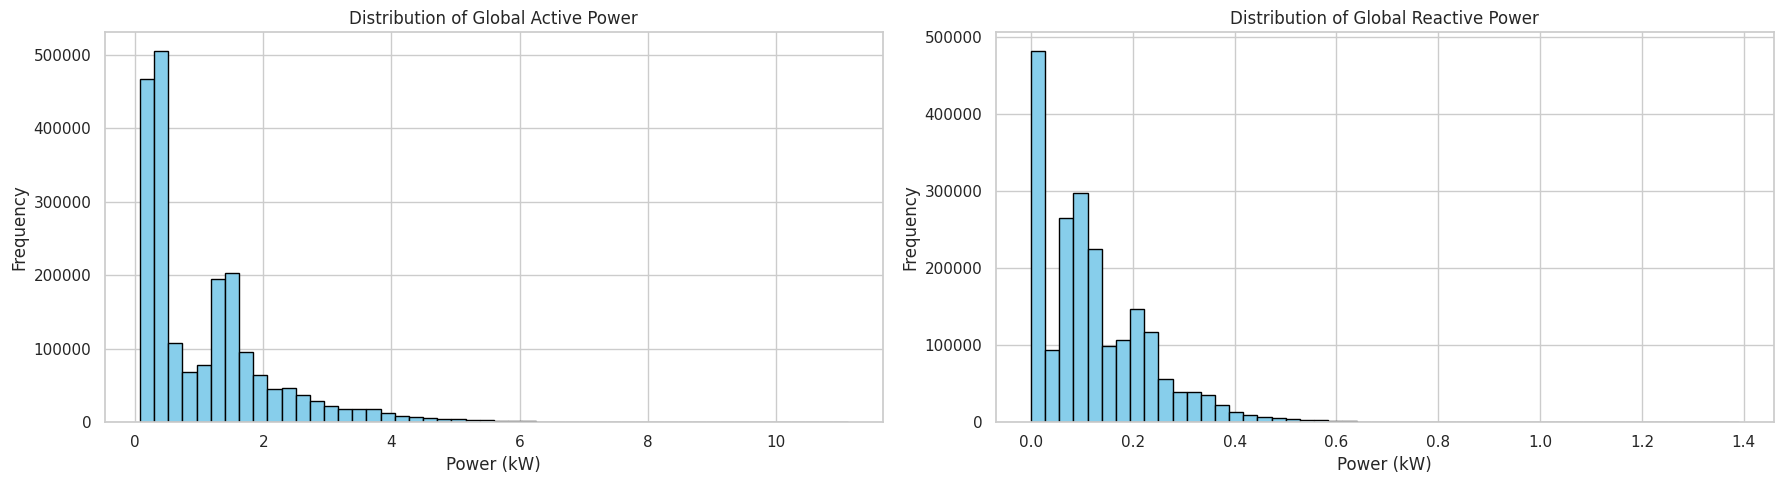

In [ ]:
# 2.(a) Histogram (Distribution of Power Consumption)

# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(18,5))

# First subplot for 'Global_active_power'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(data_frame['Global_active_power'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")
plt.title("Distribution of Global Active Power")

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(data_frame['Global_reactive_power'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")
plt.title("Distribution of Global Reactive Power")

# Show both plots side by side
plt.tight_layout()  # Automatically adjusts the spacing to fit both plots
plt.show()



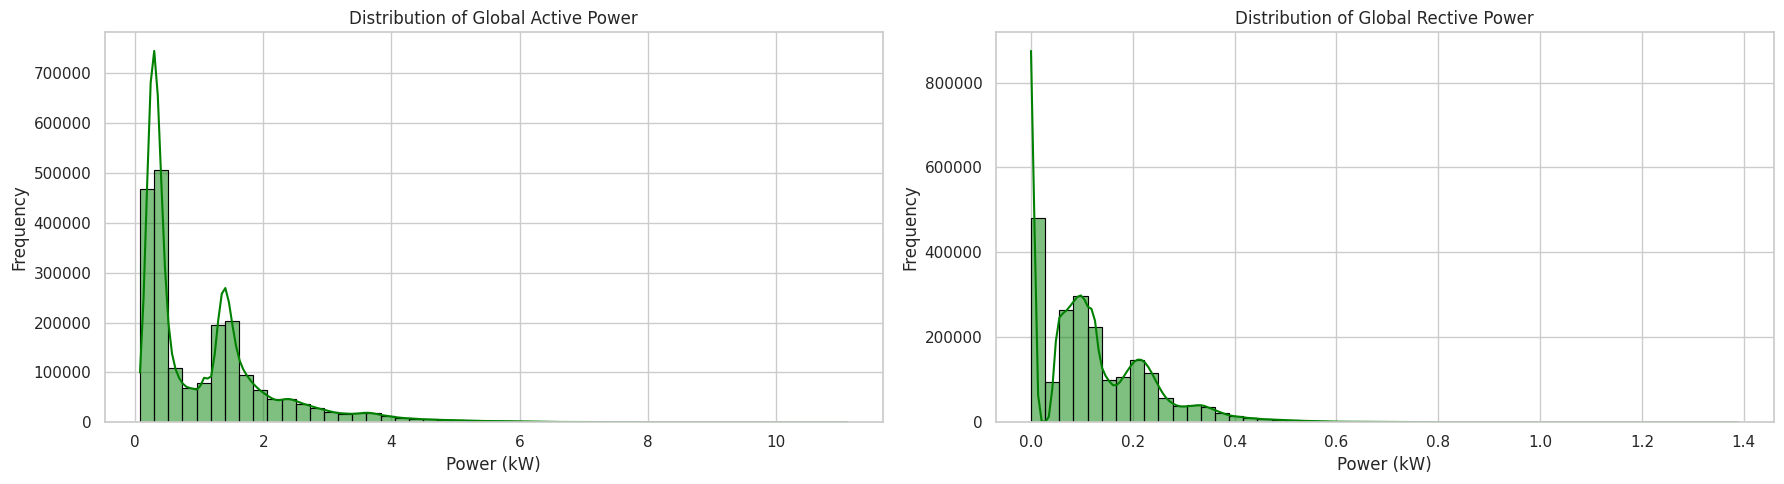

In [ ]:
#2.(b) using sns histplot ...

# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(18,5))

# First subplot for 'Global_active_power'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(data_frame['Global_active_power'], bins=50, kde=True, color='green', edgecolor='black')
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")
plt.title("Distribution of Global Active Power")

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(data_frame['Global_reactive_power'], bins=50, kde=True, color='green', edgecolor='black')
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")
plt.title("Distribution of Global Rective Power")

# Show both plots side by side
plt.tight_layout()  # Automatically adjusts the spacing to fit both plots
plt.show()


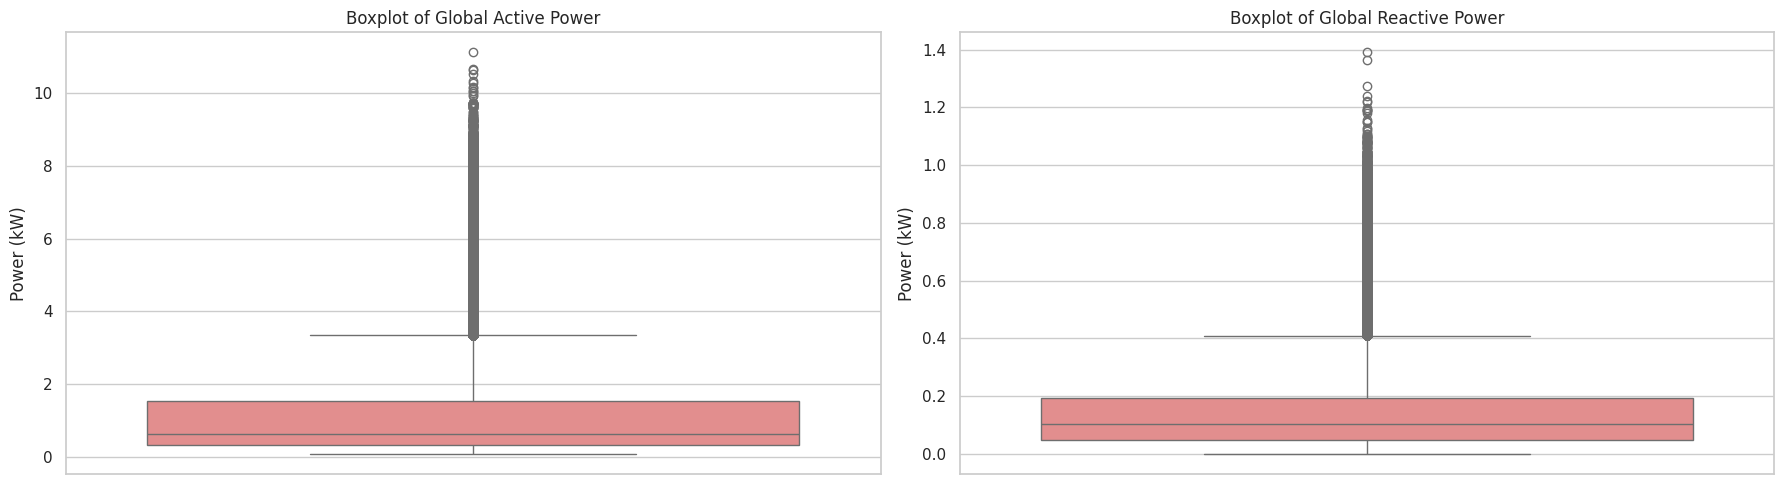

In [ ]:
# 3. Box plot detecting outliers .

# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(18,5))

# First subplot for 'Global_active_power'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.boxplot(y=data_frame['Global_active_power'], color='lightcoral')
plt.ylabel("Power (kW)")
plt.title("Boxplot of Global Active Power")

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.boxplot(y=data_frame['Global_reactive_power'], color='lightcoral')
plt.ylabel("Power (kW)")
plt.title("Boxplot of Global Reactive Power")

# Show both plots side by side
plt.tight_layout()  # Automatically adjusts the spacing to fit both plots
plt.show()

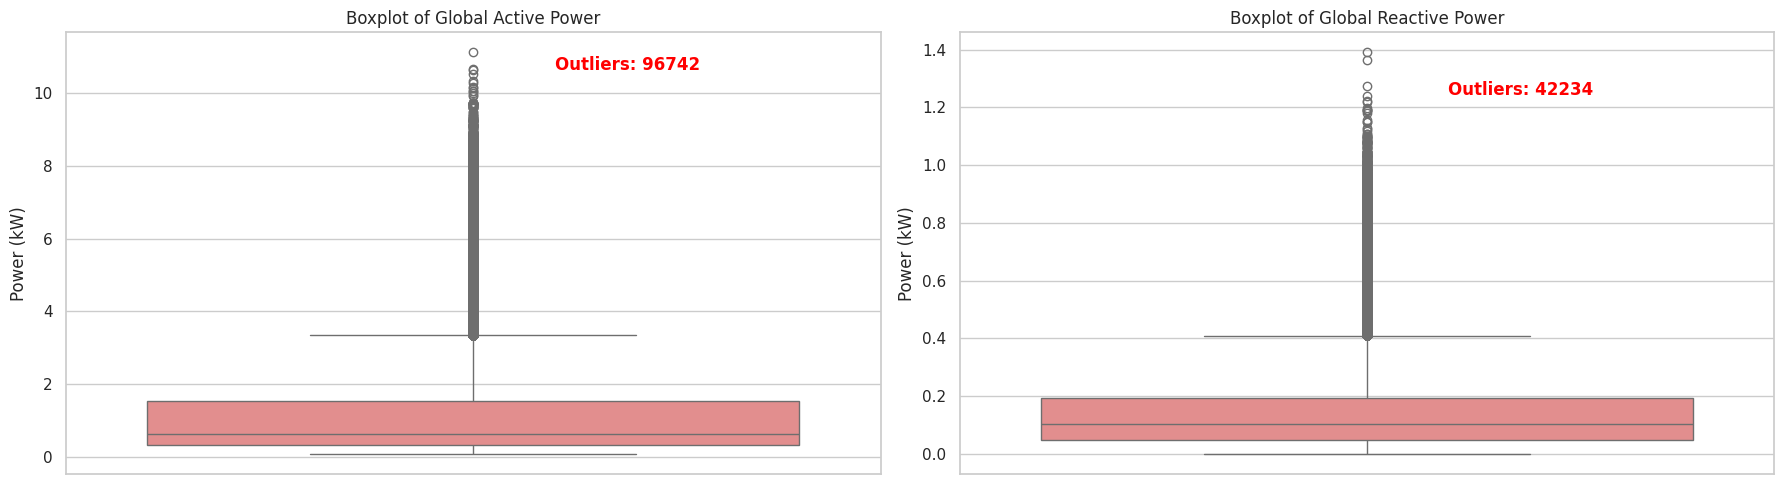

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(18,5))

# First subplot for 'Global_active_power'
plt.subplot(1, 2, 1)
data = data_frame['Global_active_power']
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_count = ((data < lower_bound) | (data > upper_bound)).sum()

sns.boxplot(y=data, color='lightcoral')
plt.ylabel("Power (kW)")
plt.title("Boxplot of Global Active Power")

# Annotate outlier count
y_max = data.max()
plt.text(
    0.1, y_max - 0.1,
    f'Outliers: {outlier_count}',
    ha='left', va='top',
    color='red', fontsize=12, weight='bold'
)

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 2, 2)
data = data_frame['Global_reactive_power']
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_count = ((data < lower_bound) | (data > upper_bound)).sum()

sns.boxplot(y=data, color='lightcoral')
plt.ylabel("Power (kW)")
plt.title("Boxplot of Global Reactive Power")

# Annotate outlier count
y_max = data.max()
plt.text(
    0.1, y_max - 0.1,
    f'Outliers: {outlier_count}',
    ha='left', va='top',
    color='red', fontsize=12, weight='bold'
)

# Show both plots side by side
plt.tight_layout()
plt.show()


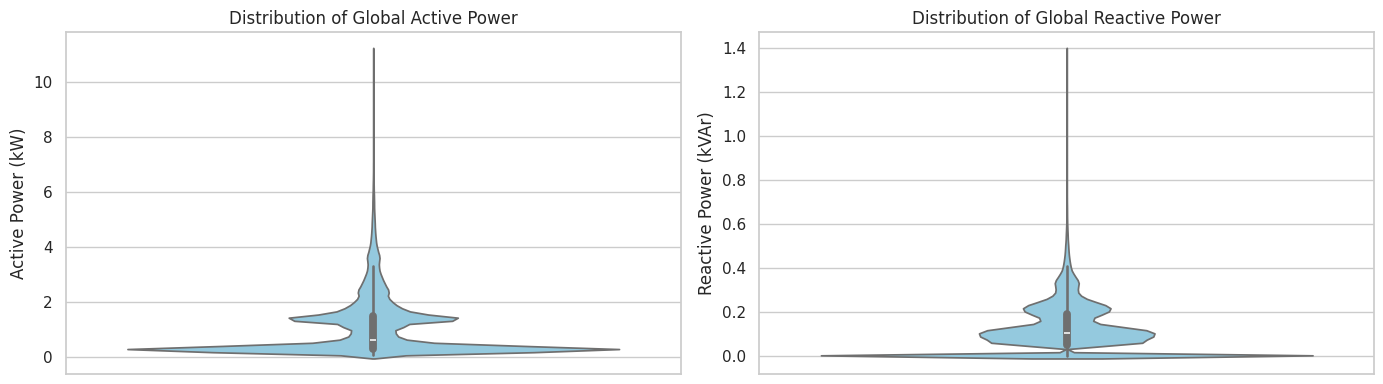

In [ ]:
# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(14, 4))

# First subplot for 'Global_active_power'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.violinplot(y=data_frame['Global_active_power'], color='skyblue')
plt.ylabel("Active Power (kW)")
plt.title("Distribution of Global Active Power")

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.violinplot(y=data_frame['Global_reactive_power'], color='skyblue')
plt.ylabel("Reactive Power (kVAr)")
plt.title("Distribution of Global Reactive Power")

# Show both plots side by side
plt.tight_layout()  # Automatically adjusts the spacing to fit both plots
plt.show()


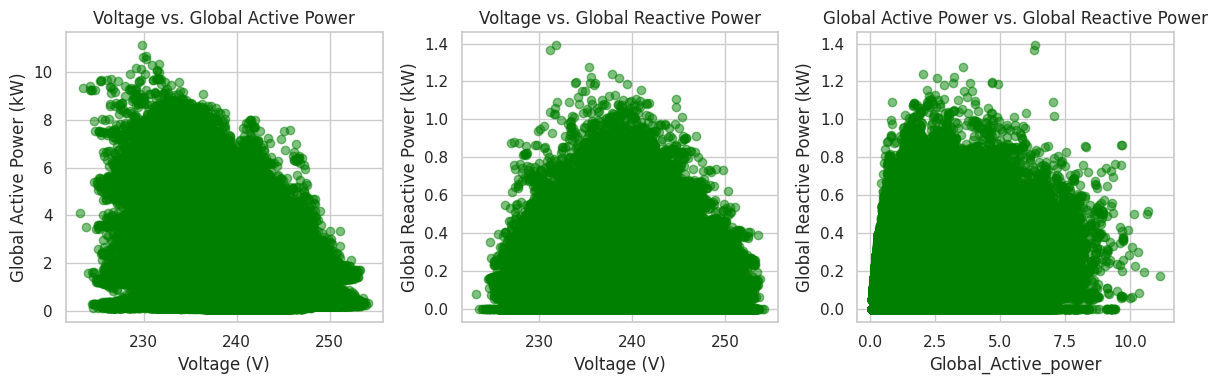

In [ ]:
#4.  Scatter Plot (Voltage vs. Power) and (active power vs reactive power)

plt.figure(figsize=(12, 4))

# First subplot for 'Global_active_power'
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.scatter(data_frame['Voltage'], data_frame['Global_active_power'], alpha=0.5, color='green')
plt.xlabel("Voltage (V)")
plt.ylabel("Global Active Power (kW)")
plt.title("Voltage vs. Global Active Power")

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.scatter(data_frame['Voltage'], data_frame['Global_reactive_power'], alpha=0.5, color='green')
plt.xlabel("Voltage (V)")
plt.ylabel("Global Reactive Power (kW)")
plt.title("Voltage vs. Global Reactive Power")

# Third subplot for 'Global_reactive_power'
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
plt.scatter(data_frame['Global_active_power'], data_frame['Global_reactive_power'], alpha=0.5, color='green')
plt.xlabel("Global_Active_power")
plt.ylabel("Global Reactive Power (kW)")
plt.title("Global Active Power vs. Global Reactive Power")

# Show both plots side by side
plt.tight_layout()  # Automatically adjusts the spacing to fit both plots
plt.show()

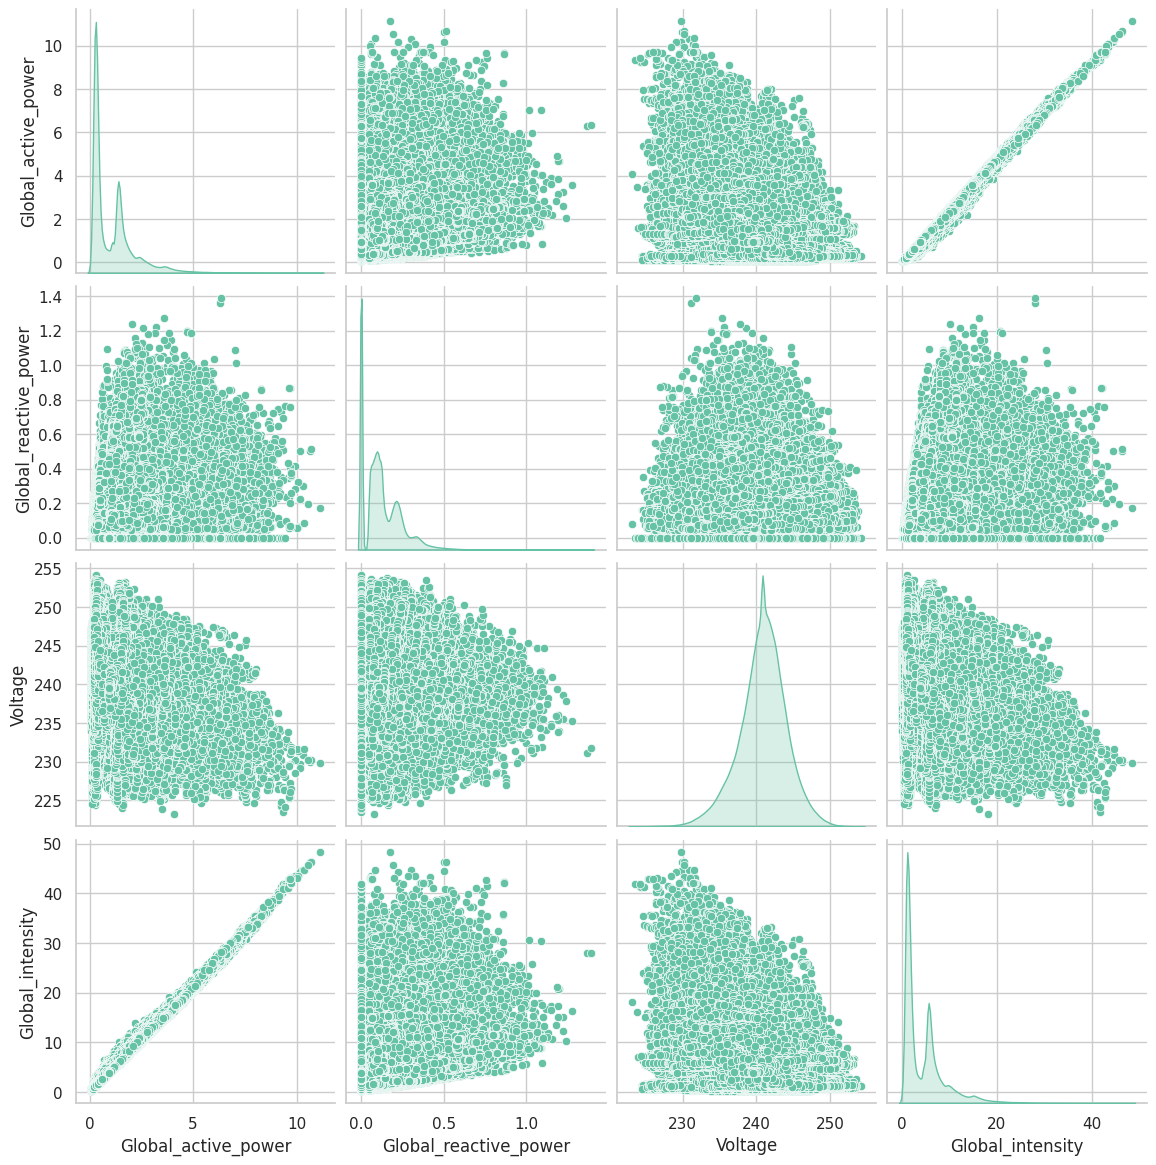

In [ ]:
# 5. Pair Plot (Feature Relationships)

sns.pairplot(data_frame[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']], diag_kind='kde')
plt.gcf().set_size_inches(12,12) # Adjust the figure size
plt.show()

# plt.figure(figsize=(10, 5)) - this does not work for pairplot ..

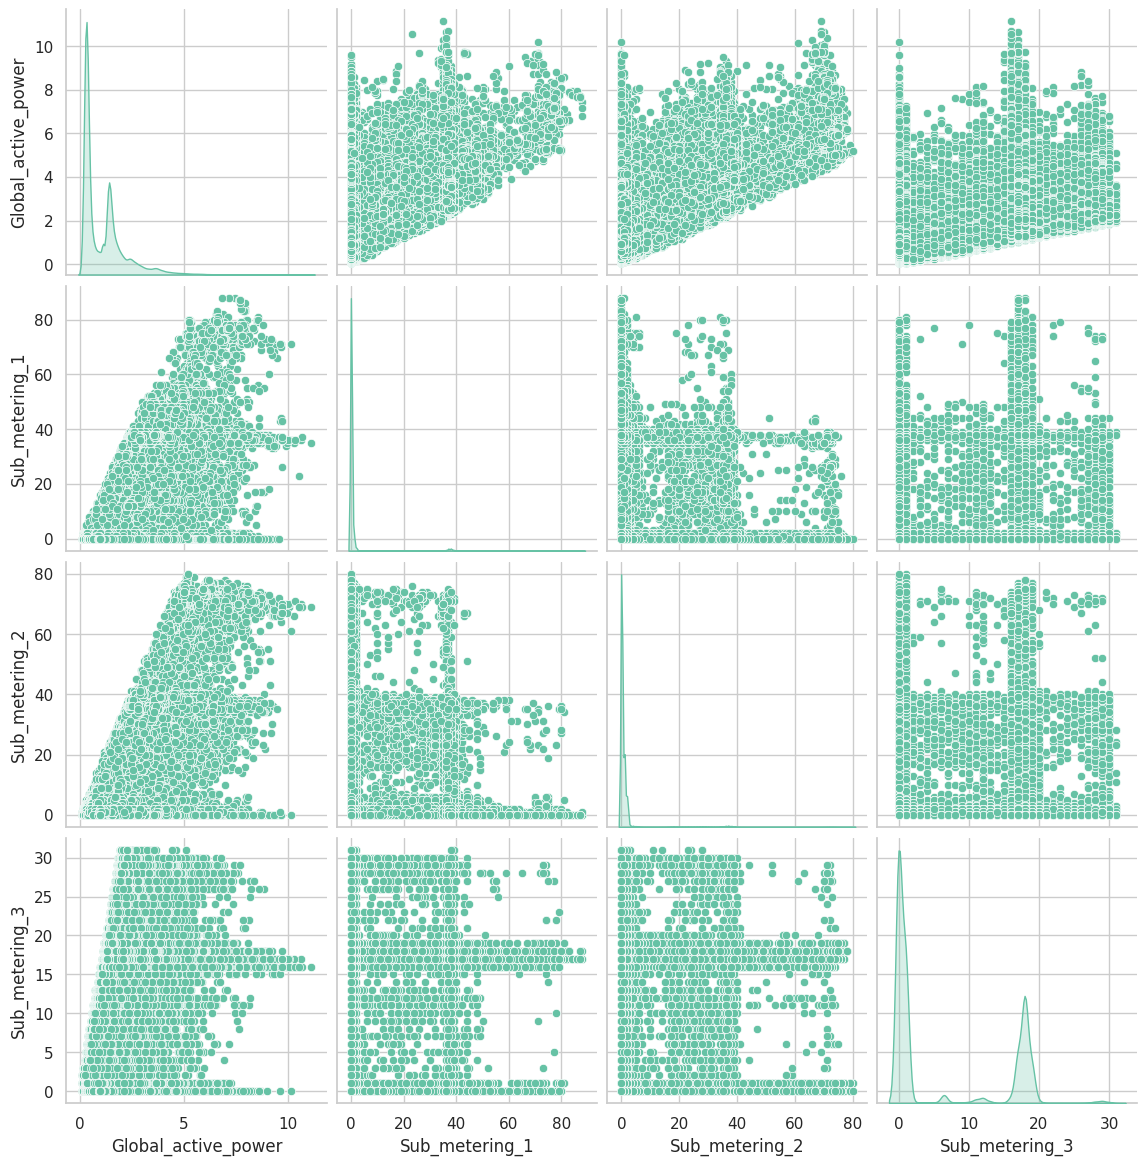

In [ ]:
sns.pairplot(data_frame[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']], diag_kind='kde')
plt.gcf().set_size_inches(12,12) # Adjust the figure size
plt.show()

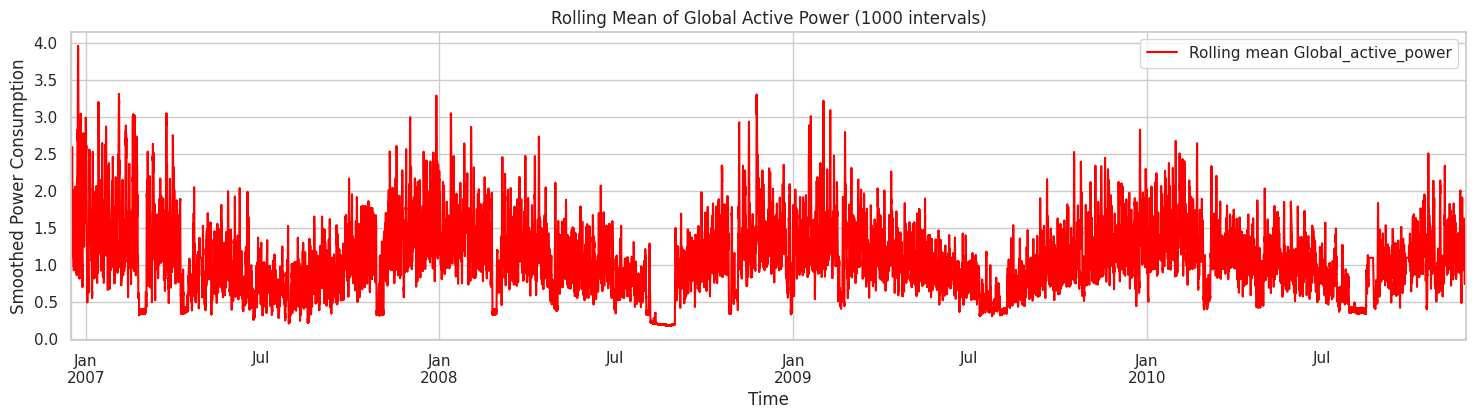

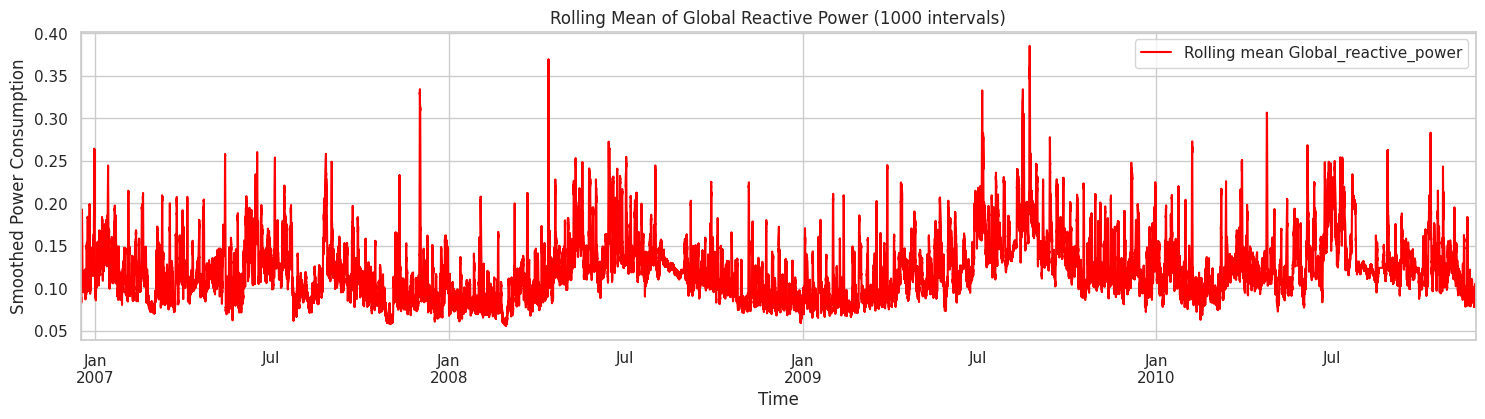

In [ ]:
# 6. Rolling Mean (Smoothing Trends)

data_frame['Global_active_power'].rolling(window=1000).mean().plot(figsize=(18,4), color='red',label="Rolling mean Global_active_power")
plt.xlabel("Time")
plt.ylabel("Smoothed Power Consumption")
plt.title("Rolling Mean of Global Active Power (1000 intervals)")
plt.legend()  # Add this to display the label
plt.show()

data_frame['Global_reactive_power'].rolling(window=1000).mean().plot(figsize=(18,4), color='red',label="Rolling mean Global_reactive_power")
plt.xlabel("Time")
plt.ylabel("Smoothed Power Consumption")
plt.title("Rolling Mean of Global Reactive Power (1000 intervals)")
plt.legend()
plt.show()

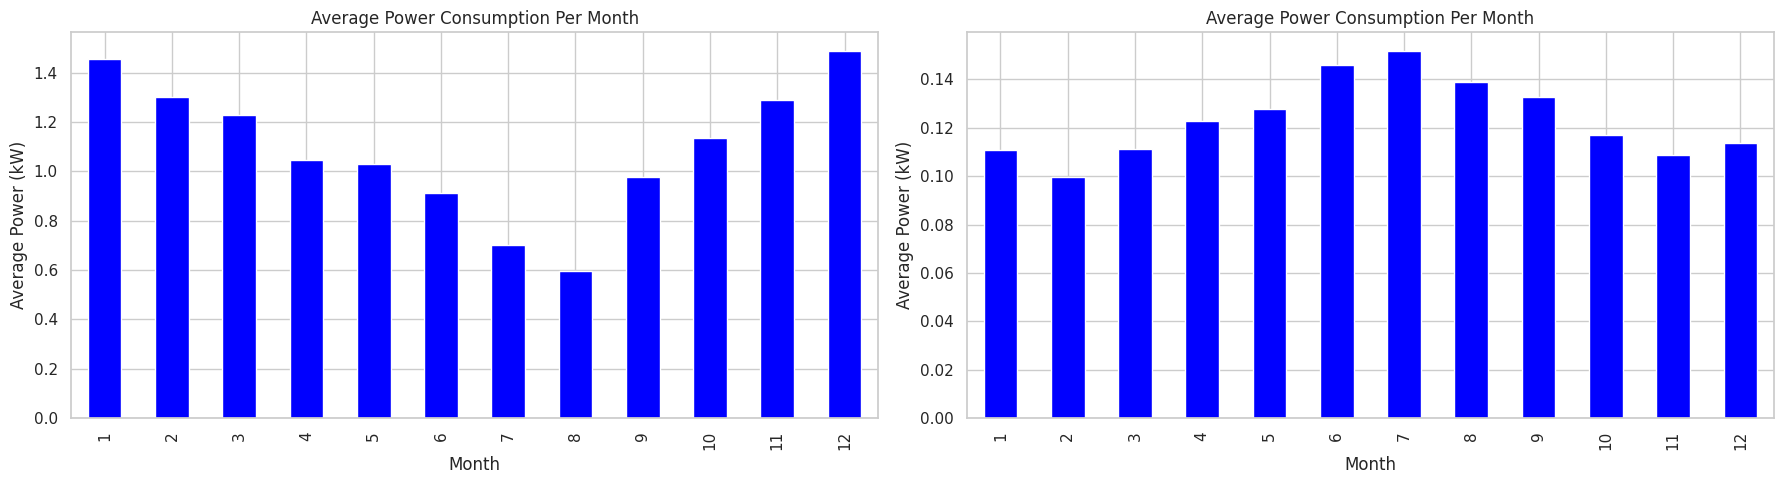

In [ ]:
#7 Monthly Trends (Seasonality Analysis)

data_frame['Year'] = data_frame.index.year
data_frame['Month'] = data_frame.index.month



'''
plt.figure(figsize=(12,5))
data_frame.groupby('Month')['Global_active_power'].mean().plot(kind='bar', color='blue')
plt.xlabel("Month")
plt.ylabel("Average Power (kW)")
plt.title("Average Power Consumption Per Month")
plt.show()

plt.figure(figsize=(12,5))
data_frame.groupby('Month')['Global_reactive_power'].mean().plot(kind='bar', color='blue')
plt.xlabel("Month")
plt.ylabel("Average Power (kW)")
plt.title("Average Power Consumption Per Month")
plt.show()

this will print in 2 different lines one after other

'''


# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(18,5))

# First subplot for 'Global_active_power'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
data_frame.groupby('Month')['Global_active_power'].mean().plot(kind='bar', color='blue')
plt.xlabel("Month")
plt.ylabel("Average Power (kW)")
plt.title("Average Power Consumption Per Month")

# Second subplot for 'Global_reactive_power'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
data_frame.groupby('Month')['Global_reactive_power'].mean().plot(kind='bar', color='blue')
plt.xlabel("Month")
plt.ylabel("Average Power (kW)")
plt.title("Average Power Consumption Per Month")

# Show both plots side by side
plt.tight_layout()  # Automatically adjusts the spacing to fit both plots
plt.show()

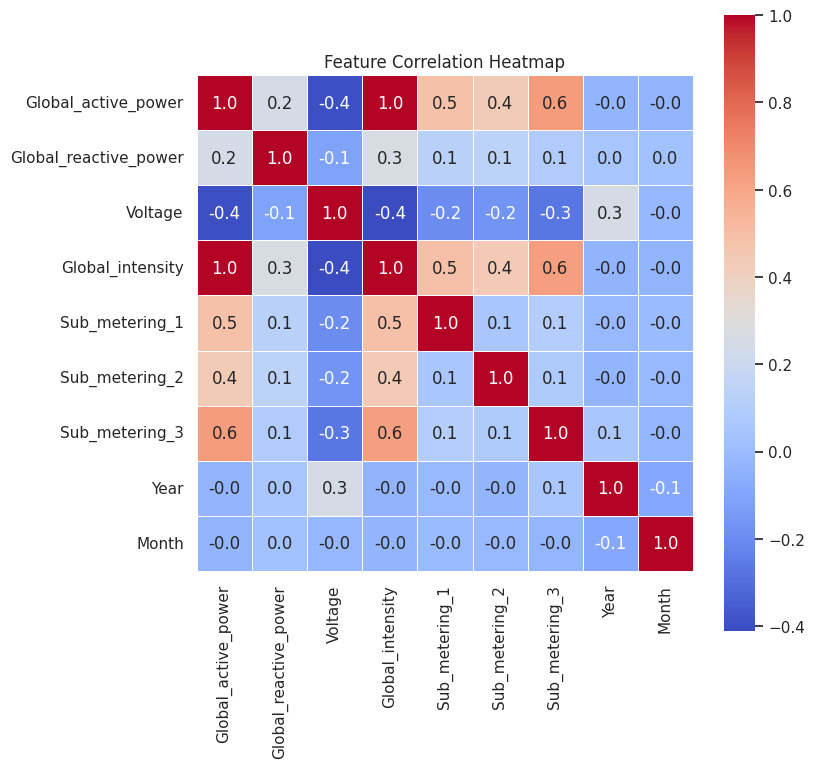

In [ ]:
#8. Heatmap (Correlation Matrix)
plt.figure(figsize=(8,8))
sns.heatmap(data_frame.corr(), cbar=True, annot=True, square=True, fmt='.1f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### **Advanced Data Visualization**

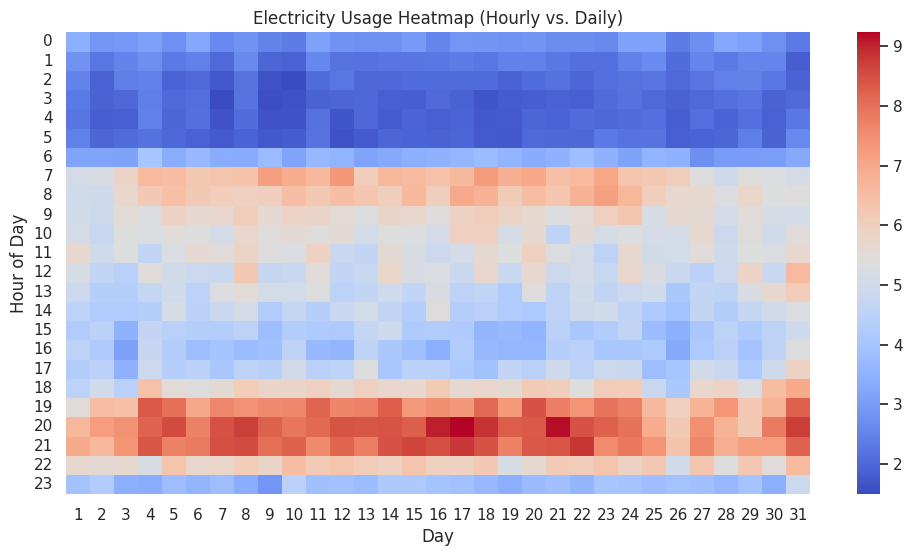

In [ ]:
# Shows at what times of day electricity usage is highest.

data_frame['Hour'] = data_frame.index.hour
data_frame['Day'] = data_frame.index.day

pivot_table = data_frame.pivot_table(values='Global_intensity', index='Hour', columns='Day', aggfunc='mean')

plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.xlabel("Day")
plt.ylabel("Hour of Day")
plt.title("Electricity Usage Heatmap (Hourly vs. Daily)")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


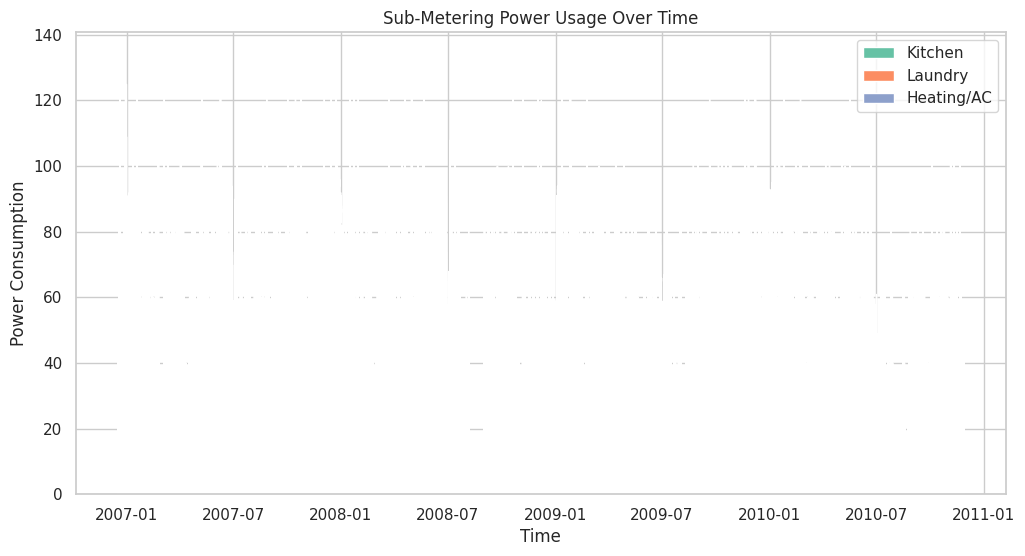

In [ ]:
# Compares how much electricity different sub-metering units consume

plt.figure(figsize=(12,6))
plt.stackplot(data_frame.index, data_frame['Sub_metering_1'], data_frame['Sub_metering_2'], data_frame['Sub_metering_3'], labels=['Kitchen', 'Laundry', 'Heating/AC'])
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.title("Sub-Metering Power Usage Over Time")
plt.legend()
plt.show()

### **TIME SERIES TO SUPERVISE SERIES for LSTM MODEL**

In [ ]:
# Select the target column (Global Active Power)
df = data_frame[['Global_active_power']].copy()

In [ ]:
df.shape

(2075259, 1)

In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

In [ ]:
df_scaled.shape

(2075259, 1)

In [ ]:
'''
LSTMs require sequential data in the format (samples, timesteps, features).

We choose 60 timesteps (last 60 minutes) to predict the next value.
This means each sample has 60 previous data points as input and 1 future value as output.

'''


# Function to create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Past 60 values
        y.append(data[i+time_steps])    # Next value to predict
    return np.array(X), np.array(y)

# Create dataset
time_steps = 60
X, y = create_sequences(df_scaled, time_steps)


In [ ]:
print(X.shape,y.shape)

(2075199, 60, 1) (2075199, 1)


In [ ]:
# Split into training (80%) and testing (20%) sets
# here we cant use random_state and shuffle otherwise it lose the context of previous data ..

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X.shape,X_train.shape,X_test.shape)
print(y.shape,y_train.shape,y_test.shape)

(2075199, 60, 1) (1660159, 60, 1) (415040, 60, 1)
(2075199, 1) (1660159, 1) (415040, 1)


### **Model Structure**

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),  # First LSTM layer
    Dropout(0.2),  # Regularization
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25),  # Fully connected layer
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss',  # You can also monitor 'val_mae'
                               patience=10,  # Number of epochs to wait before stopping
                               restore_best_weights=True,  # Restore model weights from the best epoch
                               verbose=1)  # Print messages when early stopping is triggered

In [ ]:
# history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))  # without early stoping

# Fit the model with early stopping
# history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping]) # this training each time crash due to limited memory


chunk_size = 500000  # Adjust based on Colab limits
epochs_per_chunk = 1  # Keep 1 if training in multiple chunks

# Simulated 'history' dictionary to store loss per epoch
history_dict = {
    'loss': [],
    'val_loss': [],
    'mae': [],
    'val_mae': []
}

# Train in chunks
for i in range(0, len(X_train), chunk_size):
    print(f"\nTraining on chunk {i // chunk_size + 1}")
    X_chunk = X_train[i:i+chunk_size]
    y_chunk = y_train[i:i+chunk_size]

    history = model.fit(
        X_chunk,
        y_chunk,
        epochs=epochs_per_chunk,
        batch_size=64,
        validation_data=(X_test, y_test), # in kaggle we try with validation split, so that test data remain unseen ...
        callbacks=[early_stopping],
        verbose=1
    )

    # Append to custom history dict
    for key in history.history:
        history_dict[key].extend(history.history[key])

# Now `history_dict` is similar to `history.history`



Training on chunk 1
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 135s 17ms/step - loss: 8.1545e-04 - mae: 0.0135 - val_loss: 3.8281e-04 - val_mae: 0.0078
Restoring model weights from the end of the best epoch: 1.

Training on chunk 2
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 125s 16ms/step - loss: 6.4254e-04 - mae: 0.0120 - val_loss: 3.7329e-04 - val_mae: 0.0069
Restoring model weights from the end of the best epoch: 1.

Training on chunk 3
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 124s 16ms/step - loss: 5.7327e-04 - mae: 0.0112 - val_loss: 3.7906e-04 - val_mae: 0.0072
Restoring model weights from the end of the best epoch: 1.

Training on chunk 4
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 6.3464e-04 - mae: 0.0122 - val_loss: 3.7710e-04 - val_mae: 0.0078
Restoring model weights from the end of the best epoch: 1.


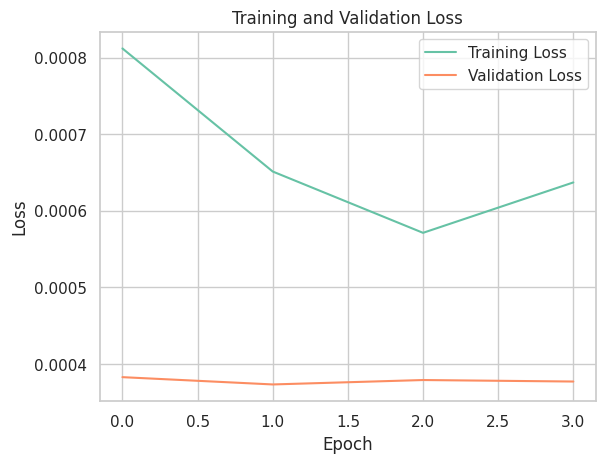

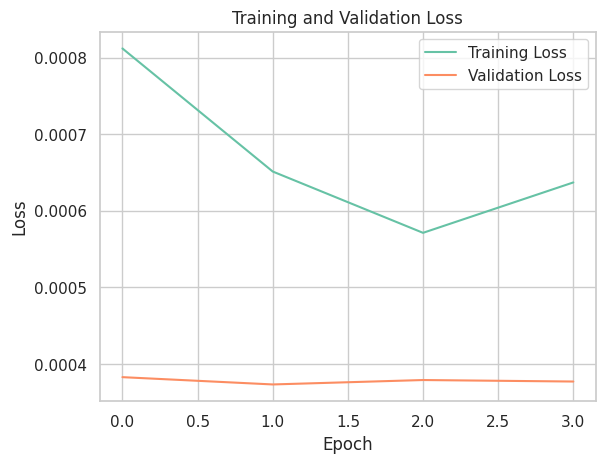

In [ ]:
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

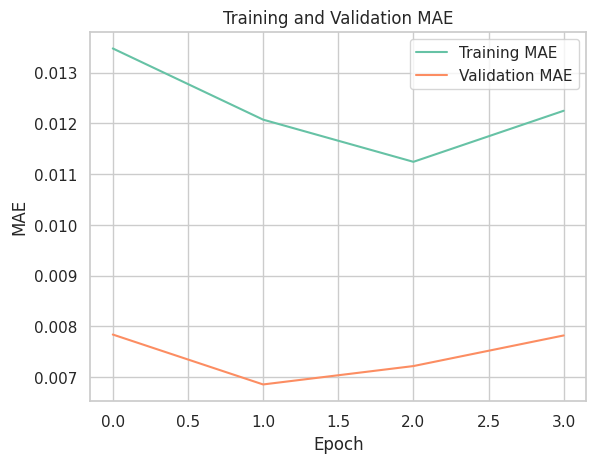

In [ ]:
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### **Model Evaluation**

In [ ]:
train_pred = model.predict(X_train)
print(type(train_pred))
print(train_pred.shape,'\n')

train_pred_inv = scaler.inverse_transform(train_pred)
print(type(train_pred_inv))
print(train_pred_inv.shape,'\n')

print(type(y_train))
print(y_train.shape,'\n')

# Optionally, inverse transform the true values for comparison
y_train_inv = scaler.inverse_transform(y_train)
print(type(y_train_inv))
print(y_train_inv.shape,'\n')


51880/51880 ━━━━━━━━━━━━━━━━━━━━ 186s 4ms/step
<class 'numpy.ndarray'>
(1660159, 1) 

<class 'numpy.ndarray'>
(1660159, 1) 

<class 'numpy.ndarray'>
(1660159, 1) 

<class 'numpy.ndarray'>
(1660159, 1) 



In [ ]:
sco1 = metrics.mean_squared_error(y_train_inv,train_pred_inv)
print("Mean Squared error on train is :", sco1)

sco2 = metrics.mean_absolute_error(y_train_inv,train_pred_inv)
print("Mean Absolute error on train is :", sco2)

sco3 = metrics.mean_absolute_percentage_error(y_train_inv,train_pred_inv)
print("Mean Absolute percentage error on train is :", sco3)

Mean Squared error on train is : 0.07345445681806424
Mean Absolute error on train is : 0.10659475128356923
Mean Absolute percentage error on train is : 0.11037768097707695


In [ ]:
test_pred = model.predict(X_test)
print(type(test_pred))
print(test_pred.shape,'\n')

test_pred_inv = scaler.inverse_transform(test_pred)
print(type(test_pred_inv))
print(test_pred_inv.shape,'\n')

print(type(y_test))
print(y_test.shape,'\n')

# Optionally, inverse transform the true values for comparison
y_test_inv = scaler.inverse_transform(y_test)
print(type(y_test_inv))
print(y_test_inv.shape,'\n')

12970/12970 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step
<class 'numpy.ndarray'>
(415040, 1) 

<class 'numpy.ndarray'>
(415040, 1) 

<class 'numpy.ndarray'>
(415040, 1) 

<class 'numpy.ndarray'>
(415040, 1) 



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

score1 = mean_squared_error(y_test_inv,test_pred_inv)
print("Mean Squared error on test is : ", score1)

score2 = mean_absolute_error(y_test_inv,test_pred_inv)
print("Mean Absolute error on test is : ", score2)

score3 = mean_absolute_percentage_error(y_test_inv,test_pred_inv) #testing mape
print("Mean Absolute percentage error on test is : ", score3)

Mean Squared error on test is :  0.0460114466044164
Mean Absolute error on test is :  0.08636465379089343
Mean Absolute percentage error on test is :  0.0992189261434554


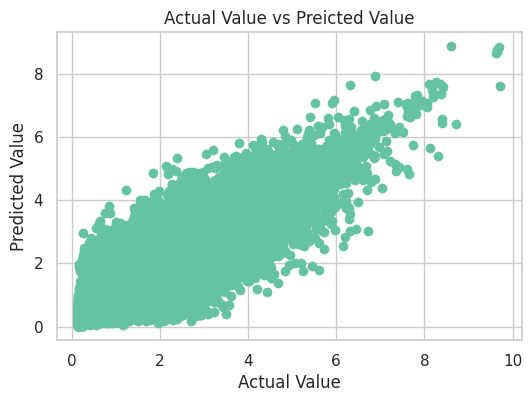

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, test_pred_inv)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual Value vs Preicted Value")
plt.show()

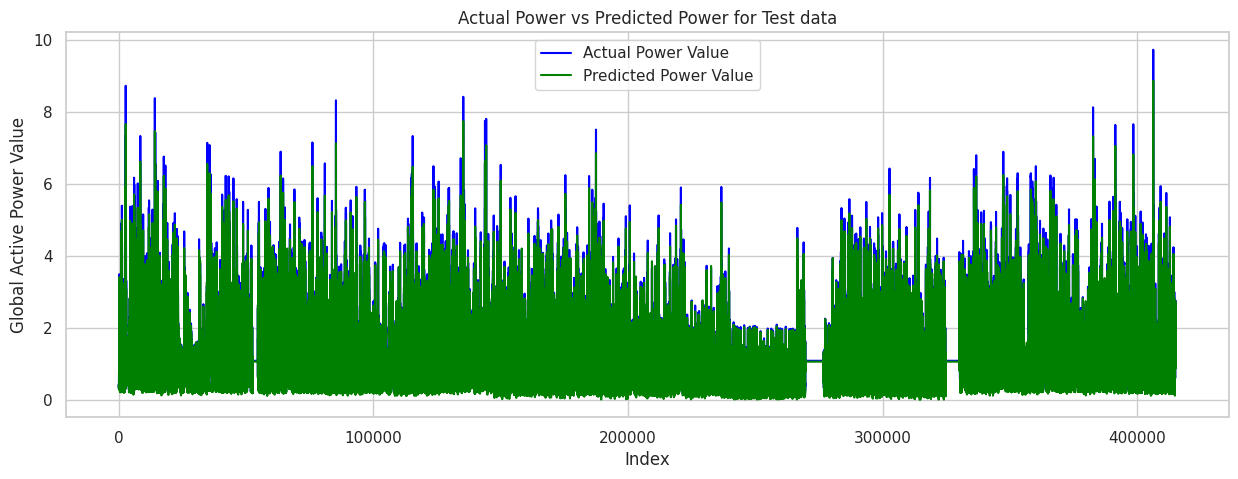

In [ ]:
y_test_inv_ = list(y_test_inv)

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv_, color='blue', label = 'Actual Power Value')
plt.plot(test_pred_inv, color='green', label='Predicted Power Value')
plt.title('Actual Power vs Predicted Power for Test data')
plt.xlabel('Index')
plt.ylabel('Global Active Power Value')
plt.legend()
plt.show()


### **Option 1 : Plot a Subset of the Data**

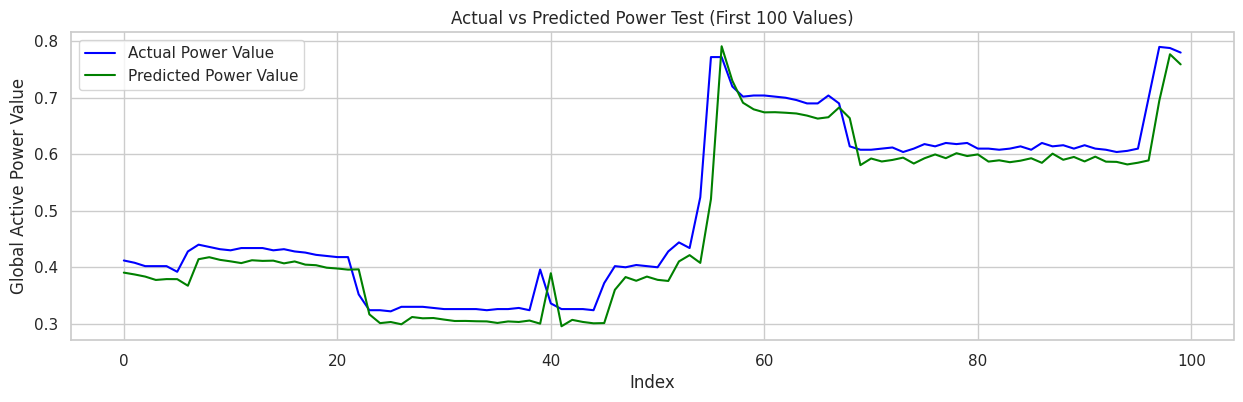

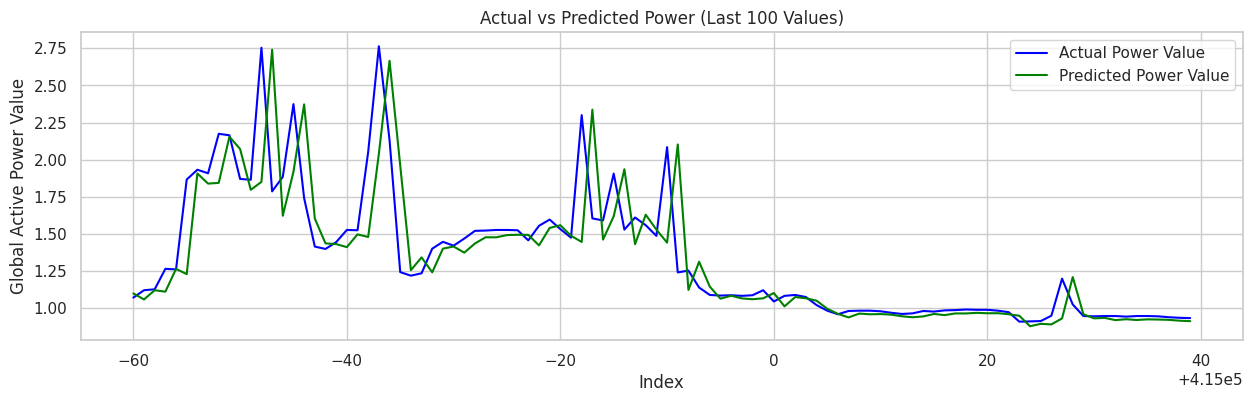

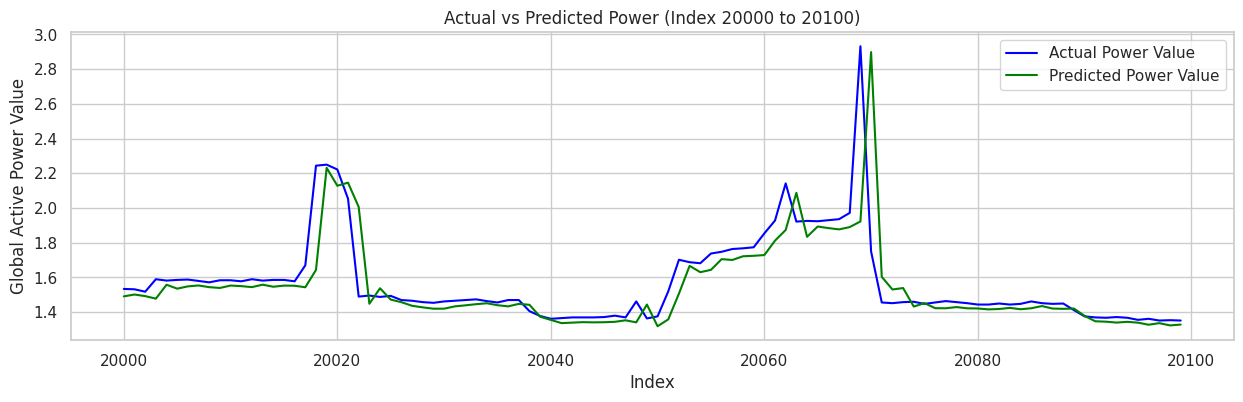

In [ ]:

# A. First 100 Values ...
subset_size = 100
plt.figure(figsize=(15, 4))
plt.plot(y_test_inv_[:subset_size], color='blue', label='Actual Power Value')
plt.plot(test_pred_inv[:subset_size], color='green', label='Predicted Power Value')
plt.title('Actual vs Predicted Power Test (First 100 Values)')
plt.xlabel('Index')
plt.ylabel('Global Active Power Value')
plt.legend()
plt.show()

# In method B, C the value of index is still 0 to 100, if we want to show the original index then this code works ..

# B ..

subset_size = 100
# Compute start index based on total length
start_index = len(y_test_inv_) - subset_size
end_index = len(y_test_inv_)

# Create the actual index range
x_vals = list(range(start_index, end_index))

plt.figure(figsize=(15, 4))
plt.plot(x_vals, y_test_inv_[-subset_size:], color='blue', label='Actual Power Value')
plt.plot(x_vals, test_pred_inv[-subset_size:], color='green', label='Predicted Power Value')
plt.title('Actual vs Predicted Power Test (Last 100 Values)')
plt.xlabel('Index')
plt.ylabel('Global Active Power Value')
plt.legend()
plt.show()

# C ..
start_index = 20000
subset_size = 100
end_index = start_index + subset_size

x_vals = list(range(start_index, end_index))

plt.figure(figsize=(15, 4))
plt.plot(x_vals, y_test_inv_[start_index:end_index], color='blue', label='Actual Power Value')
plt.plot(x_vals, test_pred_inv[start_index:end_index], color='green', label='Predicted Power Value')
plt.title(f'Actual vs Predicted Power Test (Index {start_index} to {end_index})')
plt.xlabel('Index')
plt.ylabel('Global Active Power Value')
plt.legend()
plt.show()



### **Option 2: Downsample the Data**

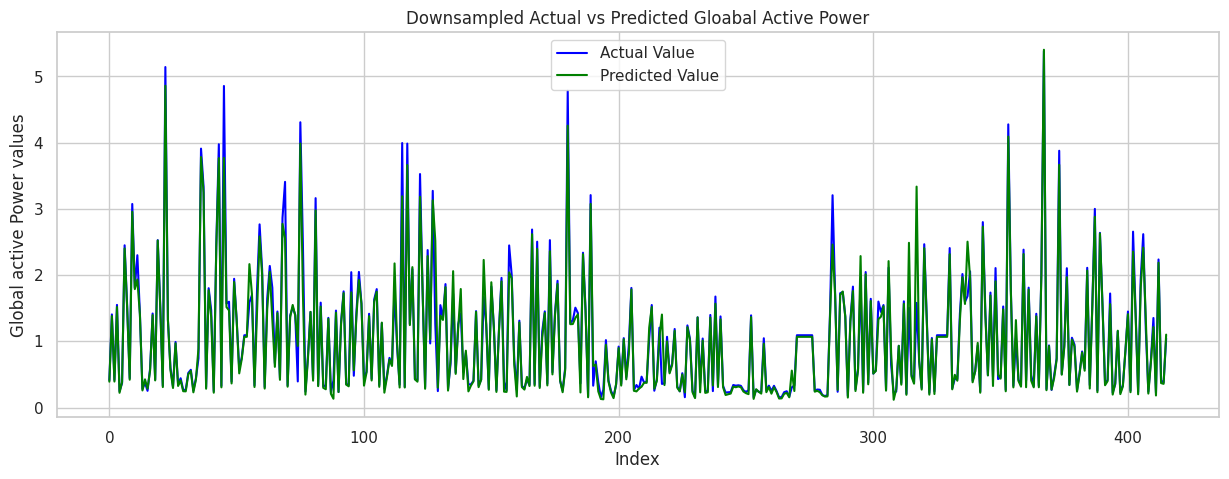

In [ ]:
# Plot every _n_th value to keep the overall trend but reduce clutter:

step = 1000  # Plot every 1000th value
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv_[::step], color='blue', label='Actual Value')
plt.plot(test_pred_inv[::step], color='green', label='Predicted Value')
plt.title('Downsampled Actual vs Predicted Gloabal Active Power')
plt.xlabel('Index')
plt.ylabel('Global active Power values')
plt.legend()
plt.show()

In [ ]:
# We can also try with other options like rolling average, and (subset + rolling average) ...

### **MAX and MIN error (absolute and percentage)**

In [ ]:
import numpy as np

# Convert to numpy arrays
actual = np.array(y_test_inv_)
predicted = np.array(test_pred_inv)

# Compute absolute errors
errors = np.abs(actual - predicted)

# Get max and min errors
max_error = np.max(errors)
min_error = np.min(errors)

# Get their index positions
max_error_indices = np.where(errors == max_error)[0]
min_error_indices = np.where(errors == min_error)[0]

# Count occurrences
max_error_freq = len(max_error_indices)
min_error_freq = len(min_error_indices)

# Extract scalar values
max_actual_value = actual[max_error_indices[0]].item()
min_actual_value = actual[min_error_indices[0]].item()

# Avoid division by zero
max_pct_error = (max_error / max_actual_value) * 100 if max_actual_value != 0 else np.inf
min_pct_error = (min_error / min_actual_value) * 100 if min_actual_value != 0 else np.inf

# Print results
print(f"Maximum Absolute Error: {max_error}")
print(f"Occurs at indices: {max_error_indices.tolist()}")
print(f"Frequency of Max Error: {max_error_freq}")
print(f"Percentage Error (at first max error index): {max_pct_error:.2f}%\n")

print(f"Minimum Absolute Error: {min_error}")
print(f"Occurs at indices: {min_error_indices.tolist()}")
print(f"Frequency of Min Error: {min_error_freq}")
print(f"Percentage Error (at first min error index): {min_pct_error:.2f}%")


Maximum Absolute Error: 3.8427112312316902
Occurs at indices: [365708]
Frequency of Max Error: 1
Percentage Error (at first max error index): 68.35%

Minimum Absolute Error: 2.384185791015625e-07
Occurs at indices: [52347]
Frequency of Min Error: 1
Percentage Error (at first min error index): 0.00%


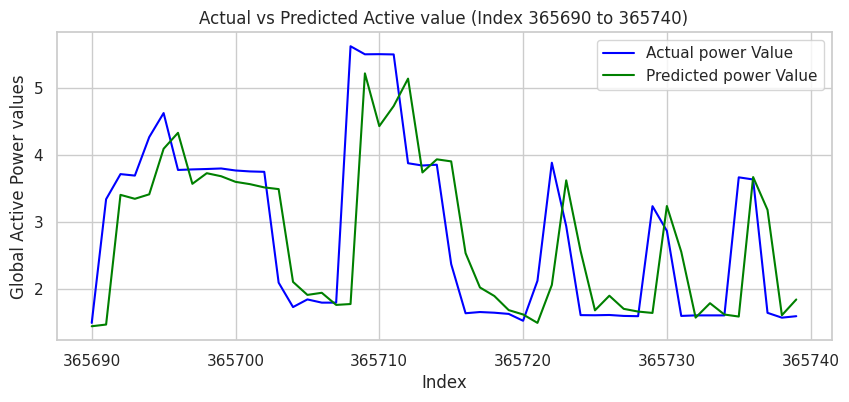

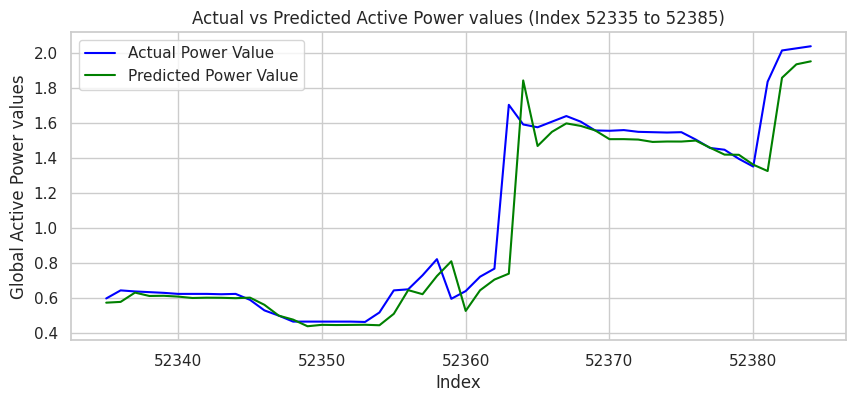

In [ ]:
# This is max error ...

start_index = 365690
subset_size = 50
end_index = start_index + subset_size

x_vals = list(range(start_index, end_index))

plt.figure(figsize=(10, 4))
plt.plot(x_vals, y_test_inv_[start_index:end_index], color='blue', label='Actual power Value')
plt.plot(x_vals, test_pred_inv[start_index:end_index], color='green', label='Predicted power Value')
plt.title(f'Actual vs Predicted Active value (Index {start_index} to {end_index})')
plt.xlabel('Index')
plt.ylabel('Global Active Power values')
plt.legend()
plt.show()


# this is min error ...
start_index = 52335
subset_size = 50
end_index = start_index + subset_size

x_vals = list(range(start_index, end_index))

plt.figure(figsize=(10, 4))
plt.plot(x_vals, y_test_inv_[start_index:end_index], color='blue', label='Actual Power Value')
plt.plot(x_vals, test_pred_inv[start_index:end_index], color='green', label='Predicted Power Value')
plt.title(f'Actual vs Predicted Active Power values (Index {start_index} to {end_index})')
plt.xlabel('Index')
plt.ylabel('Global Active Power values')
plt.legend()
plt.show()

### **Count percentage error for all points**

In [ ]:
import numpy as np

# Ensure inputs are numpy arrays
actual = np.array(y_test_inv_).flatten()
predicted = np.array(test_pred_inv).flatten()

# Compute absolute percentage error, handling division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    percentage_errors = np.abs((actual - predicted) / actual) * 100
    percentage_errors = np.nan_to_num(percentage_errors, nan=np.inf, posinf=np.inf)

# Define thresholds
thresholds = [1, 5, 10, 20, 30, 40, 50, 60, 65]

# Count how many percentage errors exceed each threshold
print("Percentage Error Threshold Analysis:")
for threshold in thresholds:
    count = np.sum(percentage_errors > threshold)
    print(f"Errors > {threshold}%: {count} points")


Percentage Error Threshold Analysis:
Errors > 1%: 390100 points
Errors > 5%: 217226 points
Errors > 10%: 94879 points
Errors > 20%: 41984 points
Errors > 30%: 24365 points
Errors > 40%: 15572 points
Errors > 50%: 10782 points
Errors > 60%: 7810 points
Errors > 65%: 6678 points


**Over 50% of your test set has less than 5% error (~198,000 points under 5% error).**

**About 77% of predictions are within 10% error (since 94,879 are >10%, meaning ~320,000 are ≤10%).**

### **Plot error percentage distribution**

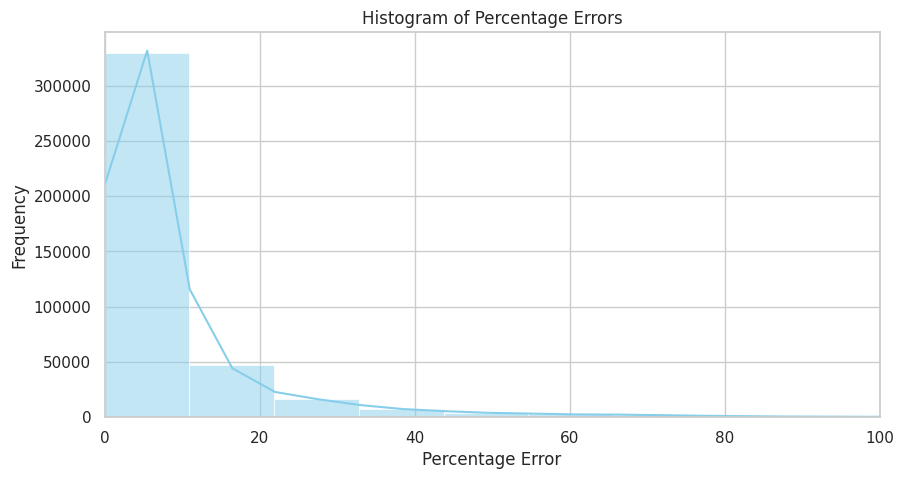

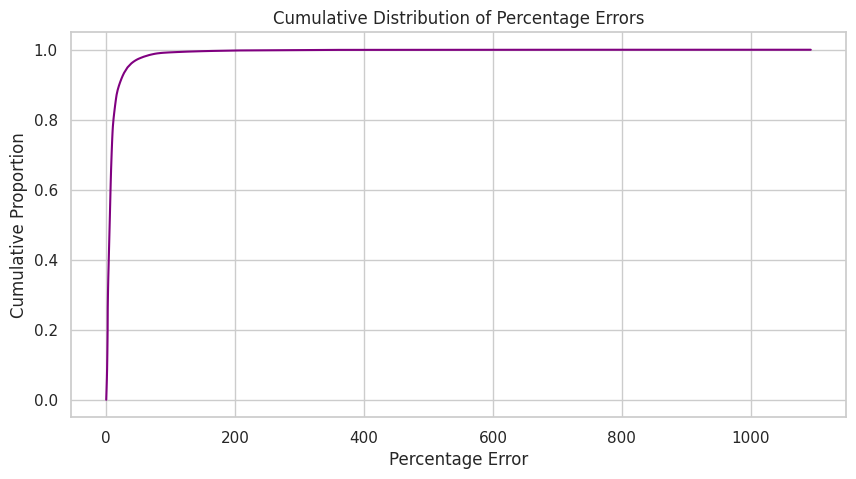

In [ ]:
# Histogram & Cumulative Distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(percentage_errors, bins=100, kde=True, color='skyblue')
plt.title("Histogram of Percentage Errors")
plt.xlabel("Percentage Error")
plt.ylabel("Frequency")
plt.xlim(0, 100)  # You can adjust this based on outliers
plt.grid(True)
plt.show()

# Cumulative distribution
sorted_errors = np.sort(percentage_errors)
cum_dist = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(10, 5))
plt.plot(sorted_errors, cum_dist, color='purple')
plt.title("Cumulative Distribution of Percentage Errors")
plt.xlabel("Percentage Error")
plt.ylabel("Cumulative Proportion")
plt.grid(True)
plt.show()


In [ ]:
# Highlight High-Error Points on Time Series

# Ensure inputs are numpy arrays
actual = np.array(y_test_inv_).flatten()
predicted = np.array(test_pred_inv).flatten()

threshold = 30  # Choose error threshold to highlight
high_error_indices = np.where(percentage_errors > threshold)[0]

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual', alpha=0.7)
plt.plot(predicted, label='Predicted', alpha=0.7)

# Highlight high-error points
plt.scatter(high_error_indices, actual[high_error_indices],
            color='red', s=10, label=f'Error > {threshold}%')

plt.title(f"Actual vs Predicted (highlighting >{threshold}% errors)")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
